<a href="https://colab.research.google.com/github/tomik062/AI_Project/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

extract data from github and merge together

In [7]:
import requests
import os
import importlib.util
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV, LeaveOneOut,KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso,ElasticNet, Ridge
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define the GitHub details
def init_process():
  repo_owner = 'tomik062'
  repo_name = 'AI_Project'
  file_path = 'extract_data.py'
  url = f'https://raw.githubusercontent.com/{repo_owner}/{repo_name}/main/{file_path}'

  # Directory to save the downloaded file
  download_dir = 'data_extraction_code'
  if not os.path.exists(download_dir):
      os.makedirs(download_dir)

  local_file_path = os.path.join(download_dir, file_path)

  # Download the file
  response = requests.get(url)
  response.raise_for_status() # Raise an exception for bad status codes

  with open(local_file_path, 'wb') as f:
      f.write(response.content)

  print(f"Downloaded {file_path} to {local_file_path}")

  # Import the function from the downloaded file
  spec = importlib.util.spec_from_file_location("extract_data_module", local_file_path)
  module = importlib.util.module_from_spec(spec)
  spec.loader.exec_module(module)
  # Call the extract_data function and print the output
  return module.extract_data()

In [8]:
def calc_features_year(data,year):
    feature_map = {
        'urbanization': 0,
        'avg birth age': 1,
        'happiness index': 2,
        'health expenditure': 3,
        'physicians per capita': 4,
        'GNI PPP': 5,
        'female labor participation': 6,
        'christians (%)': 7,
        'muslims (%)': 8,
        'no religion (%)': 9,
        'buddhists (%)': 10,
        'hindus (%)': 11,
        'jews (%)': 12,
        'other religion (%)': 13,
        'in Asia-Pacific':14,
        'in Europe':15,
        'in Latin America-Caribbean':16,
        'in Middle East-North Africa':17,
        'in North America':18,
        'in Sub-Saharan Africa':19,
        'post-HS education men (%)': 20,
        'Post-HS education women (%)': 21,
        'human development index': 22,
        'gender inequality index': 23,
        'first marriage age women': 24,
        'first marriage age men': 25,
        'maternity leave index': 26,
        'work hours men': 27,
        'work hours women': 28,
        'abortion rate': 29,
        'social media users': 30
    }
    countries_with_data = sorted(list(set([key[0] for key in data.keys() if key[1] == year])))
    index = pd.MultiIndex.from_product([countries_with_data, [year]], names=['country', 'year'])
    df = pd.DataFrame(index=index, columns=feature_map.keys())
    target=[]
    # Populate the DataFrame
    for (country, yr) in index:
        key = (country, yr)
        features = data[key][1]
        target.append(data[key][0])
        for feature_name, feature_index in feature_map.items():
            if feature_index < len(features):
              df.loc[key, feature_name] = features[feature_index]
              if str(features[feature_index]) =='nan':
                df.loc[key, feature_name]=handle_missing_values(data,feature_index,country,year)
    return df,target



def handle_missing_values(data, feature_index, country, year):
    # try taking the value from the last 2 years
    for i in range(1, 3):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and str(past_data[feature_index])!='nan':
                return past_data[feature_index]

    # otherwise if missing last 2 years, linearly extrapulate from last 6 years
    recent_years_data = []
    for i in range(6,0,-1):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and not pd.isna(past_data[feature_index]):
                 recent_years_data.append((past_year, past_data[feature_index]))

    if len(recent_years_data) >= 2:
        years = [item[0] for item in recent_years_data]
        values = [item[1] for item in recent_years_data]
        last_value = values[-1]
        # Linear extrapolation using linear regression with polyfit
        try:
            m, c = np.polyfit(years, values, 1)
            extrapolated_value = m * year + c

            # Check if extrapolated value is within 50% of last value
            if last_value != 0 and abs(extrapolated_value - last_value) / abs(last_value) > 0.3:
                return last_value
            elif last_value == 0 and abs(extrapolated_value) > 0.3 * np.mean(values): # Handle edge case where last_value is 0
                 return last_value
            else:
                return extrapolated_value
        except np.linalg.LinAlgError:
            # Handle cases where polyfit fails (e.g., all years are the same)
            return last_value # Return the last known value
    elif len(recent_years_data) == 1:
         # If only one data point in the last 10 years, use that value
         return recent_years_data[0][1]

    # If still missing after checking last 10 years, return NaN
    return np.nan

In [9]:
def find_missing_features(df_features):

  # Identify countries with and without NaN values
  countries_with_nan = df_features[df_features.isnull().any(axis=1)].index.tolist()
  countries_without_nan = df_features.dropna().index.tolist()
  countries_with_one_nan = df_features[df_features.isnull().sum(axis=1) == 1].index.tolist()

  # Print the results
  print("Countries with NaN values in their features:")
  print(countries_with_nan)
  print("\nCountries without NaN values in their features:")
  print(countries_without_nan)
  print("\nCountries with exactly one NaN value in their features:")
  print(countries_with_one_nan)

  print(f"\nNumber of countries with NaN values: {len(countries_with_nan)}")
  print(f"Number of countries without NaN values: {len(countries_without_nan)}")
  print(f"Number of countries with exactly one NaN value: {len(countries_with_one_nan)}")

  # Group countries by their single missing feature
  missing_features_grouped = {}
  if countries_with_one_nan:
      for country in countries_with_one_nan:
          missing_feature_name = df_features.loc[country].isnull().idxmax()
          if missing_feature_name not in missing_features_grouped:
              missing_features_grouped[missing_feature_name] = []
          missing_features_grouped[missing_feature_name].append(str(country))

      # Print countries grouped by missing feature
      print("\nMissing feature for countries with exactly one NaN:")
      for feature, countries in missing_features_grouped.items():
          print(f"  Missing feature is '{feature}':")
          print(f"    Countries: {', '.join(countries)}")

process all the data:
add some missing data, split to train and test and normalize

In [32]:
def process_2023_data(data_output):
    df_features, target = calc_features_year(data_output, 2023)
    missing_values_to_fill = {
        'abortion rate': {
            'Cyprus': 7,'Ireland': 6.7,'Malaysia': 11,
            'Mauritania': 42,'Malta': 3,'Morocco': 25, 'Congo, Rep.': 39
        },
        'maternity leave index': {
            'Albania': 23.23,'Bosnia and Herzegovina': 52.14,
            'Kazakhstan': 18,'Georgia': 7.59,'Kyrgyz Republic': 18,
            'Moldova': 18,'Angola': 13,'Armenia': 20,
            'Azerbaijan': 18,'Malawi': 12.86,'Bhutan': 8,
            'Tanzania': 12,'Tajikistan': 20,'North Macedonia': 39,
            'Liberia': 12.86,'Suriname': 0,'Uzbekistan': 18
        },
        'gender inequality index':{
            'Central African Republic':0.682
        },
        'physicians per capita':{
            'Somalia': 0.048, 'Viet Nam': 1.25
        }
    }

    # Fill in missing values using the dictionary
    for feature, country_values in missing_values_to_fill.items():
        for country, value in country_values.items():
            if (country,2023) in df_features.index:
                df_features.loc[(country,2023), feature] = value

    # Convert all columns to numeric, coercing errors
    df_features = df_features.apply(pd.to_numeric, errors='coerce')

    # Create a DataFrame for the target variable
    y = pd.Series(target, index=df_features.index, name='target')

    # Combine features and target into a single DataFrame for easier NaN handling
    combined_df = pd.concat([df_features, y], axis=1)

    # Remove rows with NaN values
    combined_df_cleaned = combined_df.dropna()

    # Separate features and target again
    X = combined_df_cleaned.drop('target', axis=1)
    y = combined_df_cleaned['target']

    return X,y

def process_multi_year_data(data_output):
  years = [2023, 2007, 1991]
  all_features = []
  all_targets = []

  for year in years:
      df_features, target = calc_features_year(data, year)
      df_features['year'] = year
      all_features.append(df_features)
      all_targets.extend(target)

  X = pd.concat(all_features)
  y = pd.Series(all_targets, index=X.index, name='target')

  columns_to_drop = [
      'christians (%)', 'muslims (%)', 'no religion (%)', 'buddhists (%)',
      'hindus (%)', 'jews (%)', 'other religion (%)', 'gender inequality index',
      'happiness index', 'first marriage age women', 'first marriage age men',
      'work hours men', 'work hours women', 'social media users', 'abortion rate',
      'health expenditure' ,'maternity leave index'
  ]

  X = X.drop(columns=columns_to_drop)
  X = X.apply(pd.to_numeric, errors='coerce')

  # Add specific missing data points (structured by feature)
  missing_values_to_fill_manual = {
      'GNI PPP': {
          ('Venezuela, RB', 2023): 20017,
          ('Syrian Arab Republic', 2007): 3914.3,
          ('Nigeria', 2007): 3260.8,
          ('Afghanistan', 1991): 1070
      },
      'female labor participation': {
          ('Grenada', 2023): 51.42
      },
      'physicians per capita': {
          ('Hong Kong SAR, China', 2023): 2.1,
          ('Hong Kong SAR, China', 2007): 1.13,
          ('India', 2007): 0.61
      },
      'urbanization': {
          ('West Bank and Gaza', 2023): 77.58,
          ('West Bank and Gaza', 2007): 73.49,
          ('South Sudan', 2023): 21.56,
          ('Montenegro', 2023): 68.5,
          ('Montenegro', 2007): 63.14,
          ('Maldives', 2023): 42.41,
          ('Maldives', 2007): 35.2,
          ('Serbia', 2023): 57.11,
          ('Serbia', 2007): 54.33
      },
      'human development index': {
          ('Sudan', 2007): 0.526,
          ('Rwanda', 1991): 0.213,
          ('Sao Tome and Principe', 1991): 0.399,
          ('Liberia', 1991): 0.22,
          ('Ethiopia', 1991): 0.166
      }
  }

  for feature, country_year_values in missing_values_to_fill_manual.items():
      if feature in X.columns:
          for (country, year), value in country_year_values.items():
              if (country, year) in X.index:
                  X.loc[(country, year), feature] = value

  combined_df = pd.concat([X, y], axis=1)
  combined_df_cleaned = combined_df.dropna()

  # Separate features and target again
  X = combined_df_cleaned.drop('target', axis=1)
  y = combined_df_cleaned['target']

  return X,y

In [11]:
def plot_features(X_train):

  # Get the list of columns
  columns = X_train.columns

  # Calculate the number of rows needed
  n_cols = 5
  n_rows = math.ceil(len(columns) / n_cols)

  # Create subplots
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
  axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

  # Plot histograms for all features
  for i, column in enumerate(columns):
      axes[i].hist(X_train[column], bins=10)
      axes[i].set_title(f'Histogram of {column}')
      axes[i].set_xlabel(column)
      axes[i].set_ylabel('Frequency')
      axes[i].grid(True)

  # Hide any unused subplots
  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

pipeline classes to prepare data

In [12]:
class Scaling2023(BaseEstimator, TransformerMixin):
    def __init__(self,log_features=None,features_to_scale=None,health_features=None):
        self.log_features=log_features or ['no religion (%)','other religion (%)','buddhists (%)','hindus (%)','jews (%)','GNI PPP']
        self.health_features=health_features or ['physicians per capita','health expenditure']
        self.features_to_scale=features_to_scale or [
            'urbanization','avg birth age','happiness index','GNI PPP','female labor participation','christians (%)','muslims (%)','no religion (%)',
            'buddhists (%)','hindus (%)','jews (%)','other religion (%)','post-HS education men (%)','post-HS education men (%)',
            'human development index','gender inequality index','first marriage age women','first marriage age men','maternity leave index',
            'work hours men','work hours women','abortion rate','social media users','healthcare index score'
        ]
        self.health_scaler=StandardScaler()
        self.scaler=StandardScaler()

    def fit(self,X,y=None):
        X_copy=X.copy()
        missing=[c for c in (self.health_features+self.log_features) if c not in X_copy.columns]
        if missing: raise KeyError(f"Missing columns: {missing}")

        self.health_scaler.fit(X_copy[self.health_features])
        h_scaled=self.health_scaler.transform(X_copy[self.health_features])
        score=h_scaled[:,0]+h_scaled[:,1]
        X_copy=X_copy.drop(columns=self.health_features)
        X_copy['healthcare index score']=score
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        self.scaler.fit(X_copy[self.features_to_scale])
        return self

    def transform(self,X):
        X_copy=X.copy()
        h_scaled=self.health_scaler.transform(X_copy[self.health_features])
        score=h_scaled[:,0]+h_scaled[:,1]
        X_copy=X_copy.drop(columns=self.health_features)
        X_copy['healthcare index score']=score
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        X_copy[self.features_to_scale]=self.scaler.transform(X_copy[self.features_to_scale])
        return X_copy

class ScalingMultiYear(BaseEstimator, TransformerMixin):
    def __init__(self,log_features=None,features_to_scale=None):
        self.log_features=log_features or ['GNI PPP','physicians per capita']
        self.features_to_scale=features_to_scale or [
            'urbanization','avg birth age','GNI PPP',
            'female labor participation','post-HS education men (%)',
            'post-HS education men (%)','human development index',
            'physicians per capita'
        ]
        self.scaler=StandardScaler()

    def fit(self,X,y=None):
        X_copy=X.copy()
        self.scaler.fit(X_copy[self.features_to_scale])
        return self

    def transform(self,X):
        X_copy=X.copy()
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        X_copy[self.features_to_scale]=self.scaler.transform(X_copy[self.features_to_scale])
        return X_copy

In [13]:
def create_health_index_score(X_train,X_test):
    scaler_healthcare = StandardScaler()
    health_features = ['physicians per capita','health expenditure']
    X_train[health_features] = scaler_healthcare.fit_transform(X_train[health_features])
    X_test[health_features] = scaler_healthcare.transform(X_test[health_features])
    X_train['healthcare index score'] = X_train['physicians per capita'] + X_train['health expenditure']
    X_test['healthcare index score'] = X_test['physicians per capita'] + X_test['health expenditure']
    X_train = X_train.drop(['physicians per capita', 'health expenditure'], axis=1)
    X_test = X_test.drop(['physicians per capita', 'health expenditure'], axis=1)
    return X_train,X_test

In [14]:
def feature_correlations(df, method):
    """Calculates and visualizes correlation matrix, and prints top 5 correlated pairs."""

    correlation_matrix = df.corr(method=method)

    plt.figure(figsize=(18, 15))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
    plt.title(f'{method.capitalize()} Correlation Heatmap of Features in X_train')
    plt.show()

    print(f"\nTop 5 most highly correlated pairs of features (absolute {method.capitalize()} correlation):")
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    stacked_corr = upper_tri.stack().sort_values(ascending=False, key=abs)
    top_5_correlated_pairs = stacked_corr.head(5)

    if top_5_correlated_pairs.empty:
        print("No correlated pairs found.")
    else:
        for (feature1, feature2), correlation in top_5_correlated_pairs.items():
            print(f"  {feature1} and {feature2}: {correlation:.4f}")


In [15]:
def analyze_target_correlation(X, y, method_name):
    combined_data = pd.concat([X, y], axis=1)
    correlation_series = combined_data.corr(method=method_name)['target'].drop('target').sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')
    plt.title(f'{method_name} Correlation of Features with Target Variable')
    plt.xlabel(f'{method_name} Correlation Coefficient')
    plt.ylabel('Features')
    plt.show()

    print(f"\n{method_name} Correlation with Target:")
    print(correlation_series)


In [16]:
def analyze_mutual_information(X, y):
    """Calculates and displays Mutual Information scores of features with the target."""
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    print("Mutual Information Scores of Features with Target Variable:")
    print(mi_scores)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')
    plt.title('Mutual Information Scores of Features with Target Variable')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

In [17]:
def gridsearch_loocv_lasso(X,y,scaler):
    pipe=Pipeline([('scaler',scaler),('lasso',Lasso())])
    param_grid={'lasso__alpha':[val*(10**i) for i in range(-3,3) for val in [1,3]]}
    gs=GridSearchCV(pipe,param_grid,cv=LeaveOneOut(),scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

def gridsearch_ridge_loocv(X,y,scaler):
    pipe=Pipeline([('scaler',scaler),('ridge',Ridge())])
    param_grid={
        'ridge__alpha':[val*(10**i) for i in range(-3,3) for val in [1,3]]
    }
    gs=GridSearchCV(pipe,param_grid,cv=LeaveOneOut(),scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

def gridsearch_random_forest(X,y,scaler):
  pipe=Pipeline([('scaler',scaler),('rf',RandomForestRegressor(random_state=42,n_jobs=-1))])
  kf=KFold(n_splits=5,shuffle=True,random_state=42)
  param_grid = {
        'rf__n_estimators': [10, 25, 100, 400],
        'rf__max_depth': [1, 2, 3, 4],
        'rf__min_samples_split': [2, 3 , 5, 9],
        'rf__min_samples_leaf': [1, 2, 4, 6],
        'rf__max_features': ['sqrt', 0.5, 1.0],
    }
  gs=GridSearchCV(pipe,param_grid,cv=kf,scoring='neg_mean_squared_error',n_jobs=-1)
  gs.fit(X,y)
  return gs


def gridsearch_xgboost(X, y,scaler):
    pipe = Pipeline([
        ('scaler', scaler),
        ('xgb', XGBRegressor(tree_method='hist',random_state=42,n_jobs=-1,importance_type='gain'))])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    param_grid = {
        'xgb__n_estimators': [10, 25, 100, 400],
        'xgb__learning_rate': [0.001, 0.01 , 0.1,0.5],
        'xgb__max_depth': [1, 2, 4],
        'xgb__min_child_weight': [1, 10],
        'xgb__subsample': [0.7],#decrease overfit
        'xgb__colsample_bytree': [0.7],#decrease overfit
        'xgb__gamma': [0, 1],
        'xgb__reg_alpha': [0, 1],
        'xgb__reg_lambda': [1,10],

    }
    gs=GridSearchCV(pipe,param_grid,cv=kf,scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

import pandas as pd

def report_grid_search(gs,X,y,model,scaler):
  best_est = gs.best_estimator_
  names = best_est.named_steps['scaler'].transform(X).columns
  idx = gs.best_index_
  cv_mse = -gs.cv_results_['mean_test_score'][idx]
  print(f"Best params: {gs.best_params_}")
  print(f"CV MSE: {cv_mse:.4f} (±{gs.cv_results_['std_test_score'][idx]:.4f})")
  print("Train accuracy:")
  accuracy_report(best_est,X,y)
  est = best_est.named_steps[model]

  if model in ['lasso','ridge']:
    coefs = pd.Series(est.coef_, index=names)
    coefs = coefs.reindex(coefs.abs().sort_values(ascending=False).index)
    print("\ncoefficients:")
    for f,c in coefs.items():
      print(f"{f}: {c:.4f}")
  else:#random forrest or xgboost
    if model=='rf':
      print("\nmean decrease in imputirty by feature:")
    if model=='xgb':
      print("\nmean gain by feature:")
    imp = pd.Series(est.feature_importances_, index=names).sort_values(ascending=False)
    for f,v in imp.items():
      print(f"{f}: {v:.4f}")

In [18]:
def gridsearch_all_models(X_train,y_train,scaler):
  print('\nlasso regressor:')
  lasso_gs = gridsearch_loocv_lasso(X_train,y_train, scaler)
  report_grid_search(lasso_gs,X_train,y_train,'lasso', scaler)
  print('\nridge regressor:')
  ridge_gs = gridsearch_ridge_loocv(X_train,y_train, scaler)
  report_grid_search(ridge_gs,X_train,y_train,'ridge', scaler)
  print('\nrandom forest regressor:')
  rf_gs = gridsearch_random_forest(X_train,y_train, scaler)
  report_grid_search(rf_gs,X_train,y_train,'rf', scaler)
  print('\nxgboost regressor:')
  xgb_gs = gridsearch_xgboost(X_train,y_train, scaler)
  report_grid_search(xgb_gs,X_train,y_train,'xgb', scaler)
  return lasso_gs, ridge_gs, rf_gs, xgb_gs


def accuracy_report(estimator,X,y):
  y_pred=estimator.predict(X)
  mse=mean_squared_error(y,y_pred)
  print(f"MSE: {mse:.4f}")

def compare_predictions(estimator, X, y):
  y_pred = estimator.predict(X)
  comparison_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred}, index=X.index)
  for index, row in comparison_df.iterrows():
      print(f"For: {index}, Actual: {row['Actual']:.4f}, Predicted: {row['Predicted']:.4f}")

In [42]:
def exec_experiments(data,isMultiYear):
  if isMultiYear:
    X,y = process_multi_year_data(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = ScalingMultiYear()
    unscaled_X_train=X_train.copy()
    unscaled_X_test=X_test.copy()
  else:#is only 2023
    X,y = process_2023_data(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    unscaled_X_train,unscaled_X_test = create_health_index_score(X_train.copy(),X_test.copy())
    scaler = Scaling2023()

  print('unscaled features')
  plot_features(unscaled_X_train)
  scaler.fit(X_train)
  scaled_train = scaler.transform(X_train)
  scaled_test = scaler.transform(X_test)
  print('scaled features')
  plot_features(scaled_train)

  #feature pairs correlations
  print('\nfeature pairs correlations:')
  feature_correlations(scaled_train, 'pearson')
  feature_correlations(scaled_train, 'spearman')
  #feature-target correlations and mutual information
  analyze_target_correlation(scaled_train, y_train, 'pearson')
  analyze_target_correlation(scaled_train, y_train, 'spearman')
  analyze_mutual_information(scaled_train, y_train)
  #run grid search of cv on all models
  lasso_gs, ridge_gs, rf_gs, xgb_gs = gridsearch_all_models(X_train,y_train, scaler)

  #correlations\MI:
  print("testing single feature relations test set:")
  analyze_target_correlation(scaled_test, y_test, 'pearson')
  analyze_target_correlation(scaled_test, y_test, 'spearman')
  analyze_mutual_information(scaled_test, y_test)

  # Calculate and print train\test MSE for each model,
  #and predictions for countries with low fertility
  low_fertility = y_test.nsmallest(10).index
  X_test_low_fertility = X_test.loc[low_fertility]
  y_test_low_fertility = y_test.loc[low_fertility]
  print("testing trained models signal strength using test set:")
  print('\nlasso regressor final results:')
  accuracy_report(lasso_gs.best_estimator_,X_test,y_test)
  compare_predictions(lasso_gs.best_estimator_, X_test_low_fertility, y_test_low_fertility)
  print('\nridge regressor final results:')
  accuracy_report(ridge_gs.best_estimator_,X_test,y_test)
  compare_predictions(ridge_gs.best_estimator_, X_test_low_fertility, y_test_low_fertility)
  print('\nrandom forest regressor final results:')
  accuracy_report(rf_gs.best_estimator_,X_test,y_test)
  compare_predictions(rf_gs.best_estimator_, X_test_low_fertility, y_test_low_fertility)
  print('\nxgboost regressor final results:')
  accuracy_report(xgb_gs.best_estimator_,X_test,y_test)
  compare_predictions(xgb_gs.best_estimator_, X_test_low_fertility, y_test_low_fertility)

  return X_train, X_test, y_train, y_test, lasso_gs, ridge_gs, rf_gs, xgb_gs

In [35]:
def prep_subgroups(isMultiYear=False):
  data = {
      'Feature/Target': [
          'target',
          'urbanization',
          'avg birth age',
          'happiness index',
          'health expenditure',
          'physicians per capita',
          'GNI PPP',
          'female labor participation',
          'christians (%)',
          'muslims (%)',
          'no religion (%)',
          'buddhists (%)',
          'hindus (%)',
          'jews (%)',
          'other religion (%)',
          'in Asia-Pacific',
          'in Europe',
          'in Latin America-Caribbean',
          'in Middle East-North Africa',
          'in North America',
          'in Sub-Saharan Africa',
          'post-HS education men (%)',
          'Post-HS education women (%)',
          'human development index',
          'gender inequality index',
          'first marriage age women',
          'first marriage age men',
          'maternity leave index',
          'work hours men',
          'work hours women',
          'abortion rate',
          'social media users'
      ],
      'Haredim': [
          6.4, 91.53, 31.3, 7.341, 4008, 3.713, 29213, 81, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 1, 0, 0, 4.2, 14, 0.847, 0.525, 22, 23, 14, 36.5, 32.5, 8.1, 0.32
      ],
      'Non Haredim jews': [
          2.5, 74.26, 31.3, 7.341, 4008, 3.713, 51498, 83, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 1, 0, 0, 31.3, 45.1, 0.959, 0.043, 28, 30, 14, 45, 38.5, 8.1, 0.911
      ],
      'Arabs': [
          2.75, 42.5, 27.7, 7.341, 4008, 3.713, 29420, 33.7, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 10.8, 23.3, 0.856, 0.237, 23.11, 26.96, 14, 43.4, 36.5, 5.99, 0.7128
      ]
  }

  # Create DataFrame
  df = pd.DataFrame(data)

  # Transpose the DataFrame so that the first column becomes the index and the other columns become rows
  df_transposed = df.set_index('Feature/Target').T

  # Separate the target variable as a Series
  target_series = df_transposed['target']
  features_df = df_transposed.drop(columns=['target'])

  if isMultiYear:
      multi_year_features = [
          'urbanization',
          'avg birth age',
          'physicians per capita',
          'GNI PPP',
          'female labor participation',
          'in Asia-Pacific',
          'in Europe',
          'in Latin America-Caribbean',
          'in Middle East-North Africa',
          'in North America',
          'in Sub-Saharan Africa',
          'post-HS education men (%)',
          'Post-HS education women (%)',
          'human development index',
      ]
      features_df = features_df[multi_year_features].copy()
      features_df['year'] = 2023

  return features_df, target_series

In [34]:
def test_subgroups(data,isMultiYear):
  if isMultiYear:
    X_train,y_train = process_multi_year_data(data)
    scaler=ScalingMultiYear()
  else:
    X_train,y_train = process_2023_data(data)
    scaler=Scaling2023()
  # Drop all instances of Israel
  israel_indices = X_train.index.get_level_values('country') == 'Israel'
  X_train = X_train.loc[~israel_indices]
  y_train = y_train.loc[~israel_indices]
  X_test,y_test= prep_subgroups()

  lasso_gs, ridge_gs, rf_gs, xgb_gs = gridsearch_all_models(X_train,y_train, scaler)

  print("testing model accuracy on sub groups")
  X_test,y_test= prep_subgroups(isMultiYear)
  print('\nlasso regressor results for subgroups:')
  compare_predictions(lasso_gs.best_estimator_,X_test,y_test)
  print('\nridge regressor final results:')
  compare_predictions(ridge_gs.best_estimator_,X_test,y_test)
  print('\nrandom forest regressor final results:')
  compare_predictions(rf_gs.best_estimator_,X_test,y_test)
  print('\nxgboost regressor final results:')
  compare_predictions(xgb_gs.best_estimator_,X_test,y_test)


Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded female-labor-participation.csv to data/female-labor-participation.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high

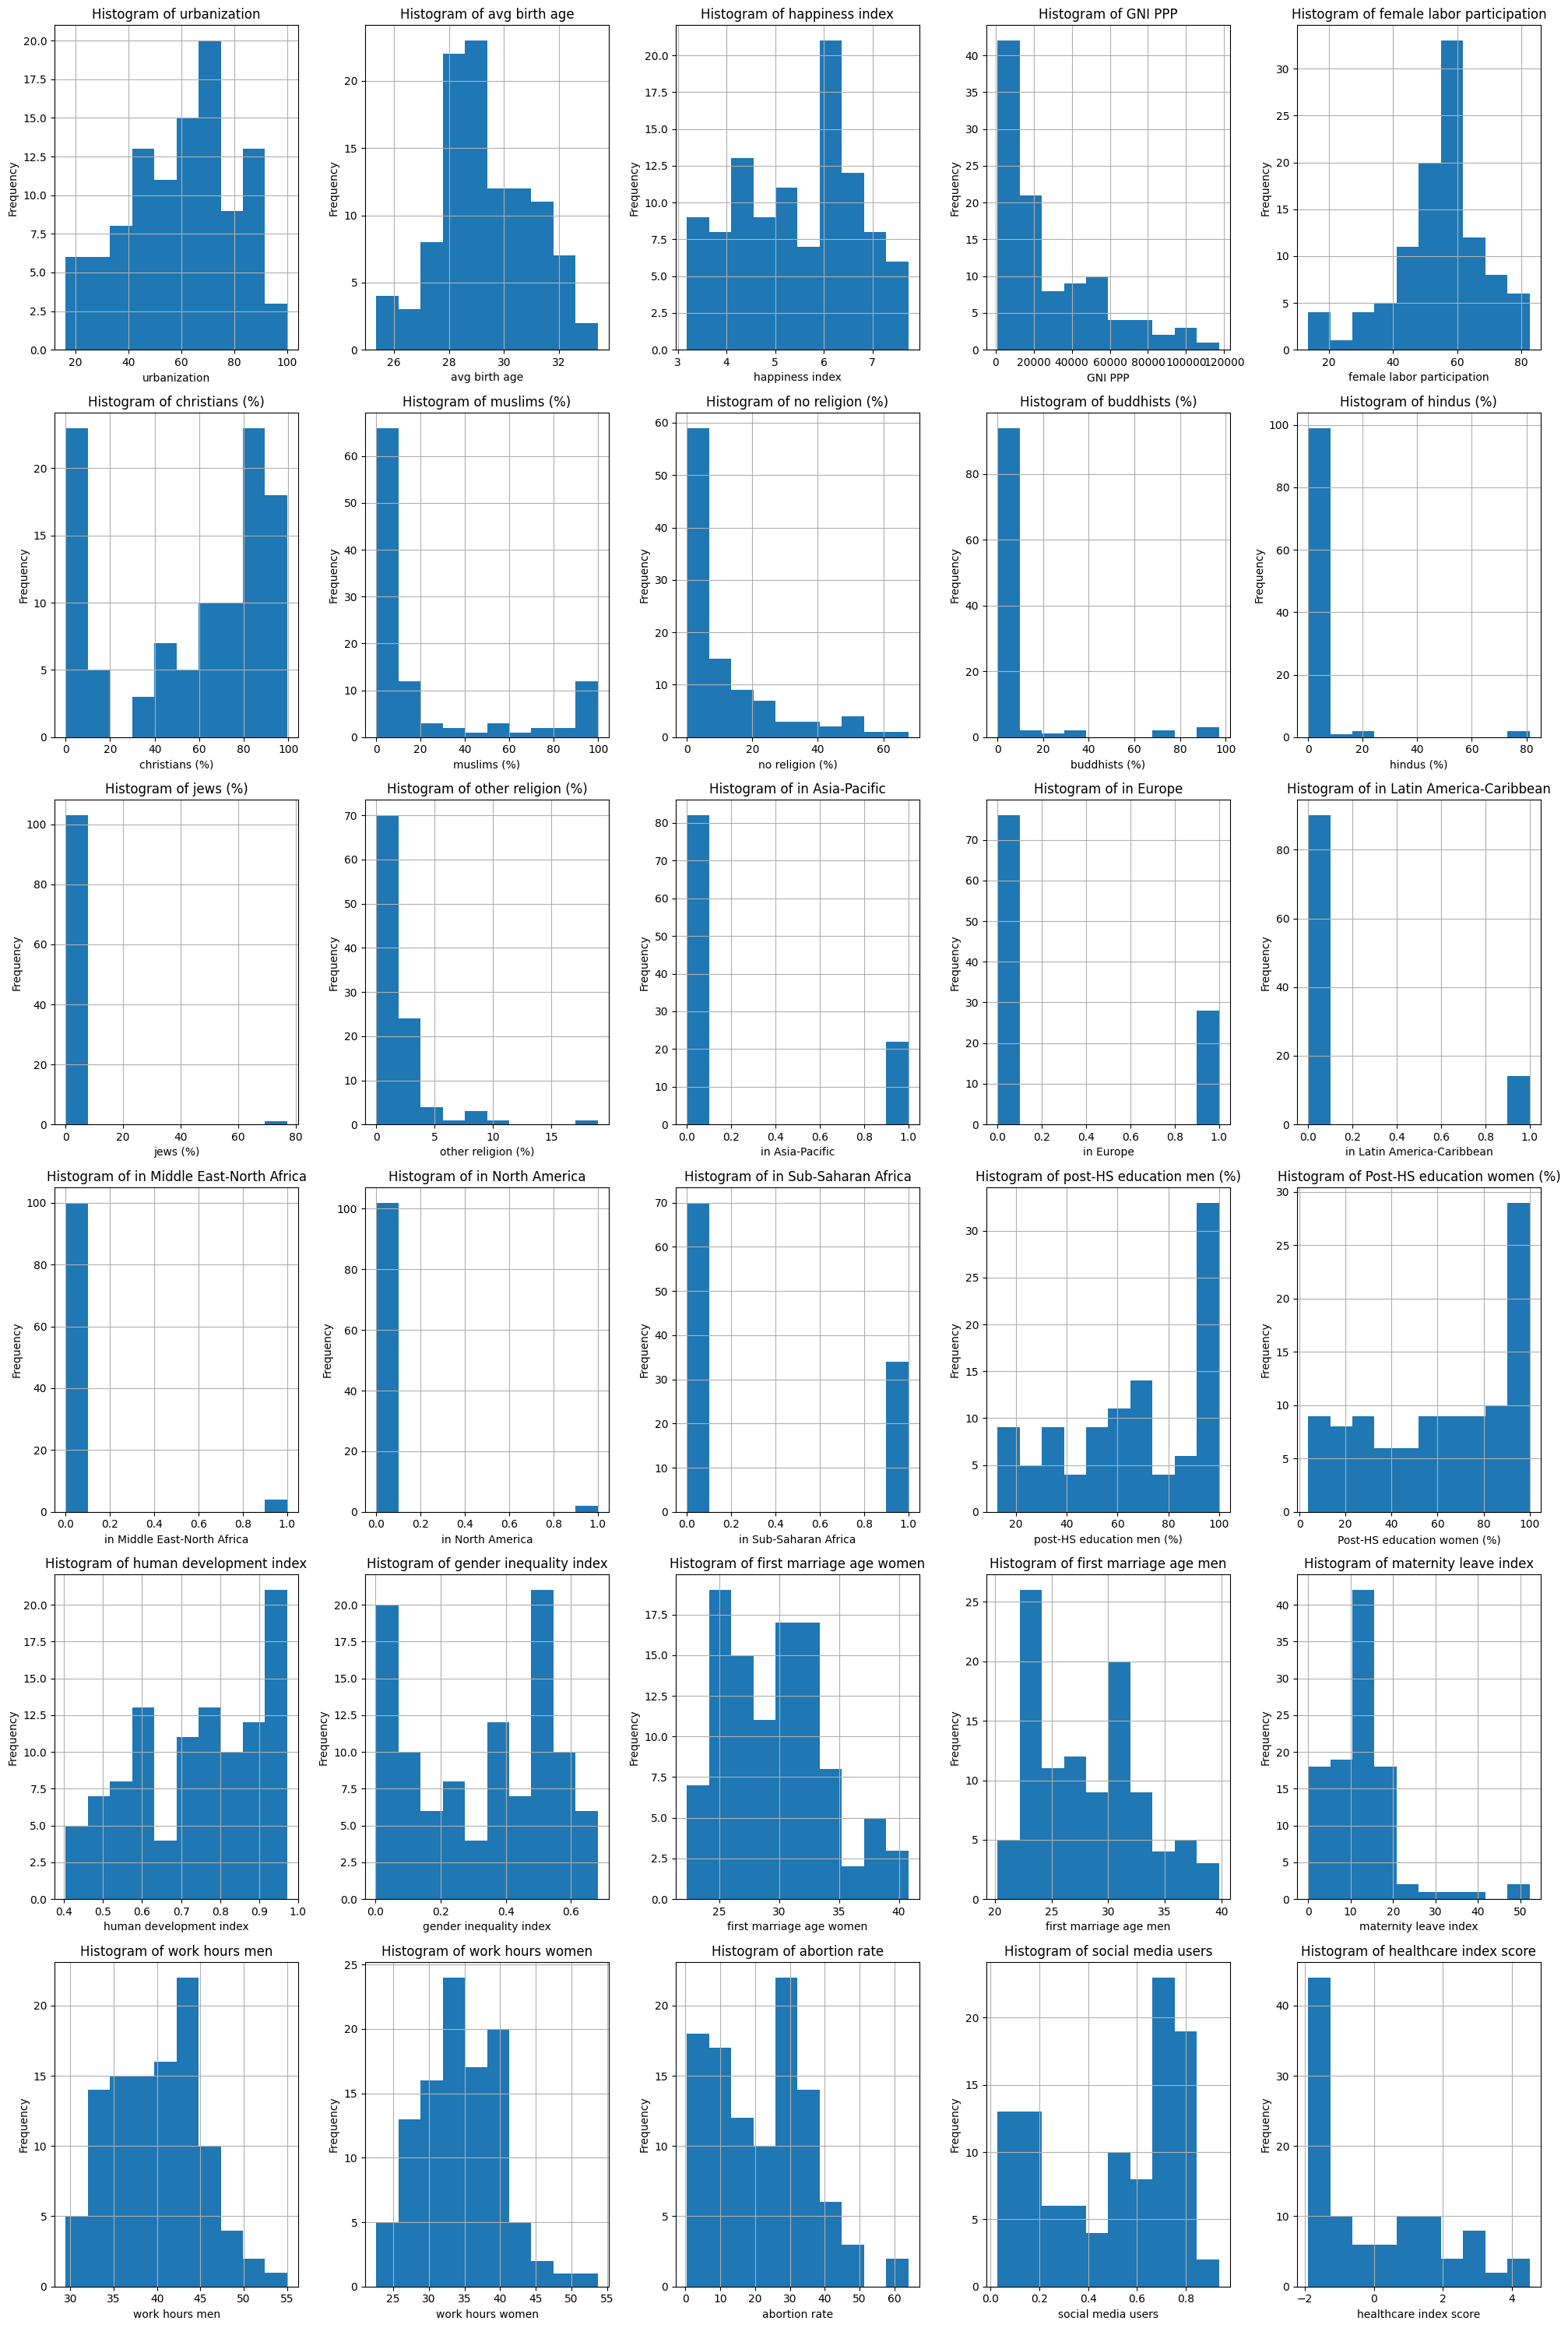

scaled features


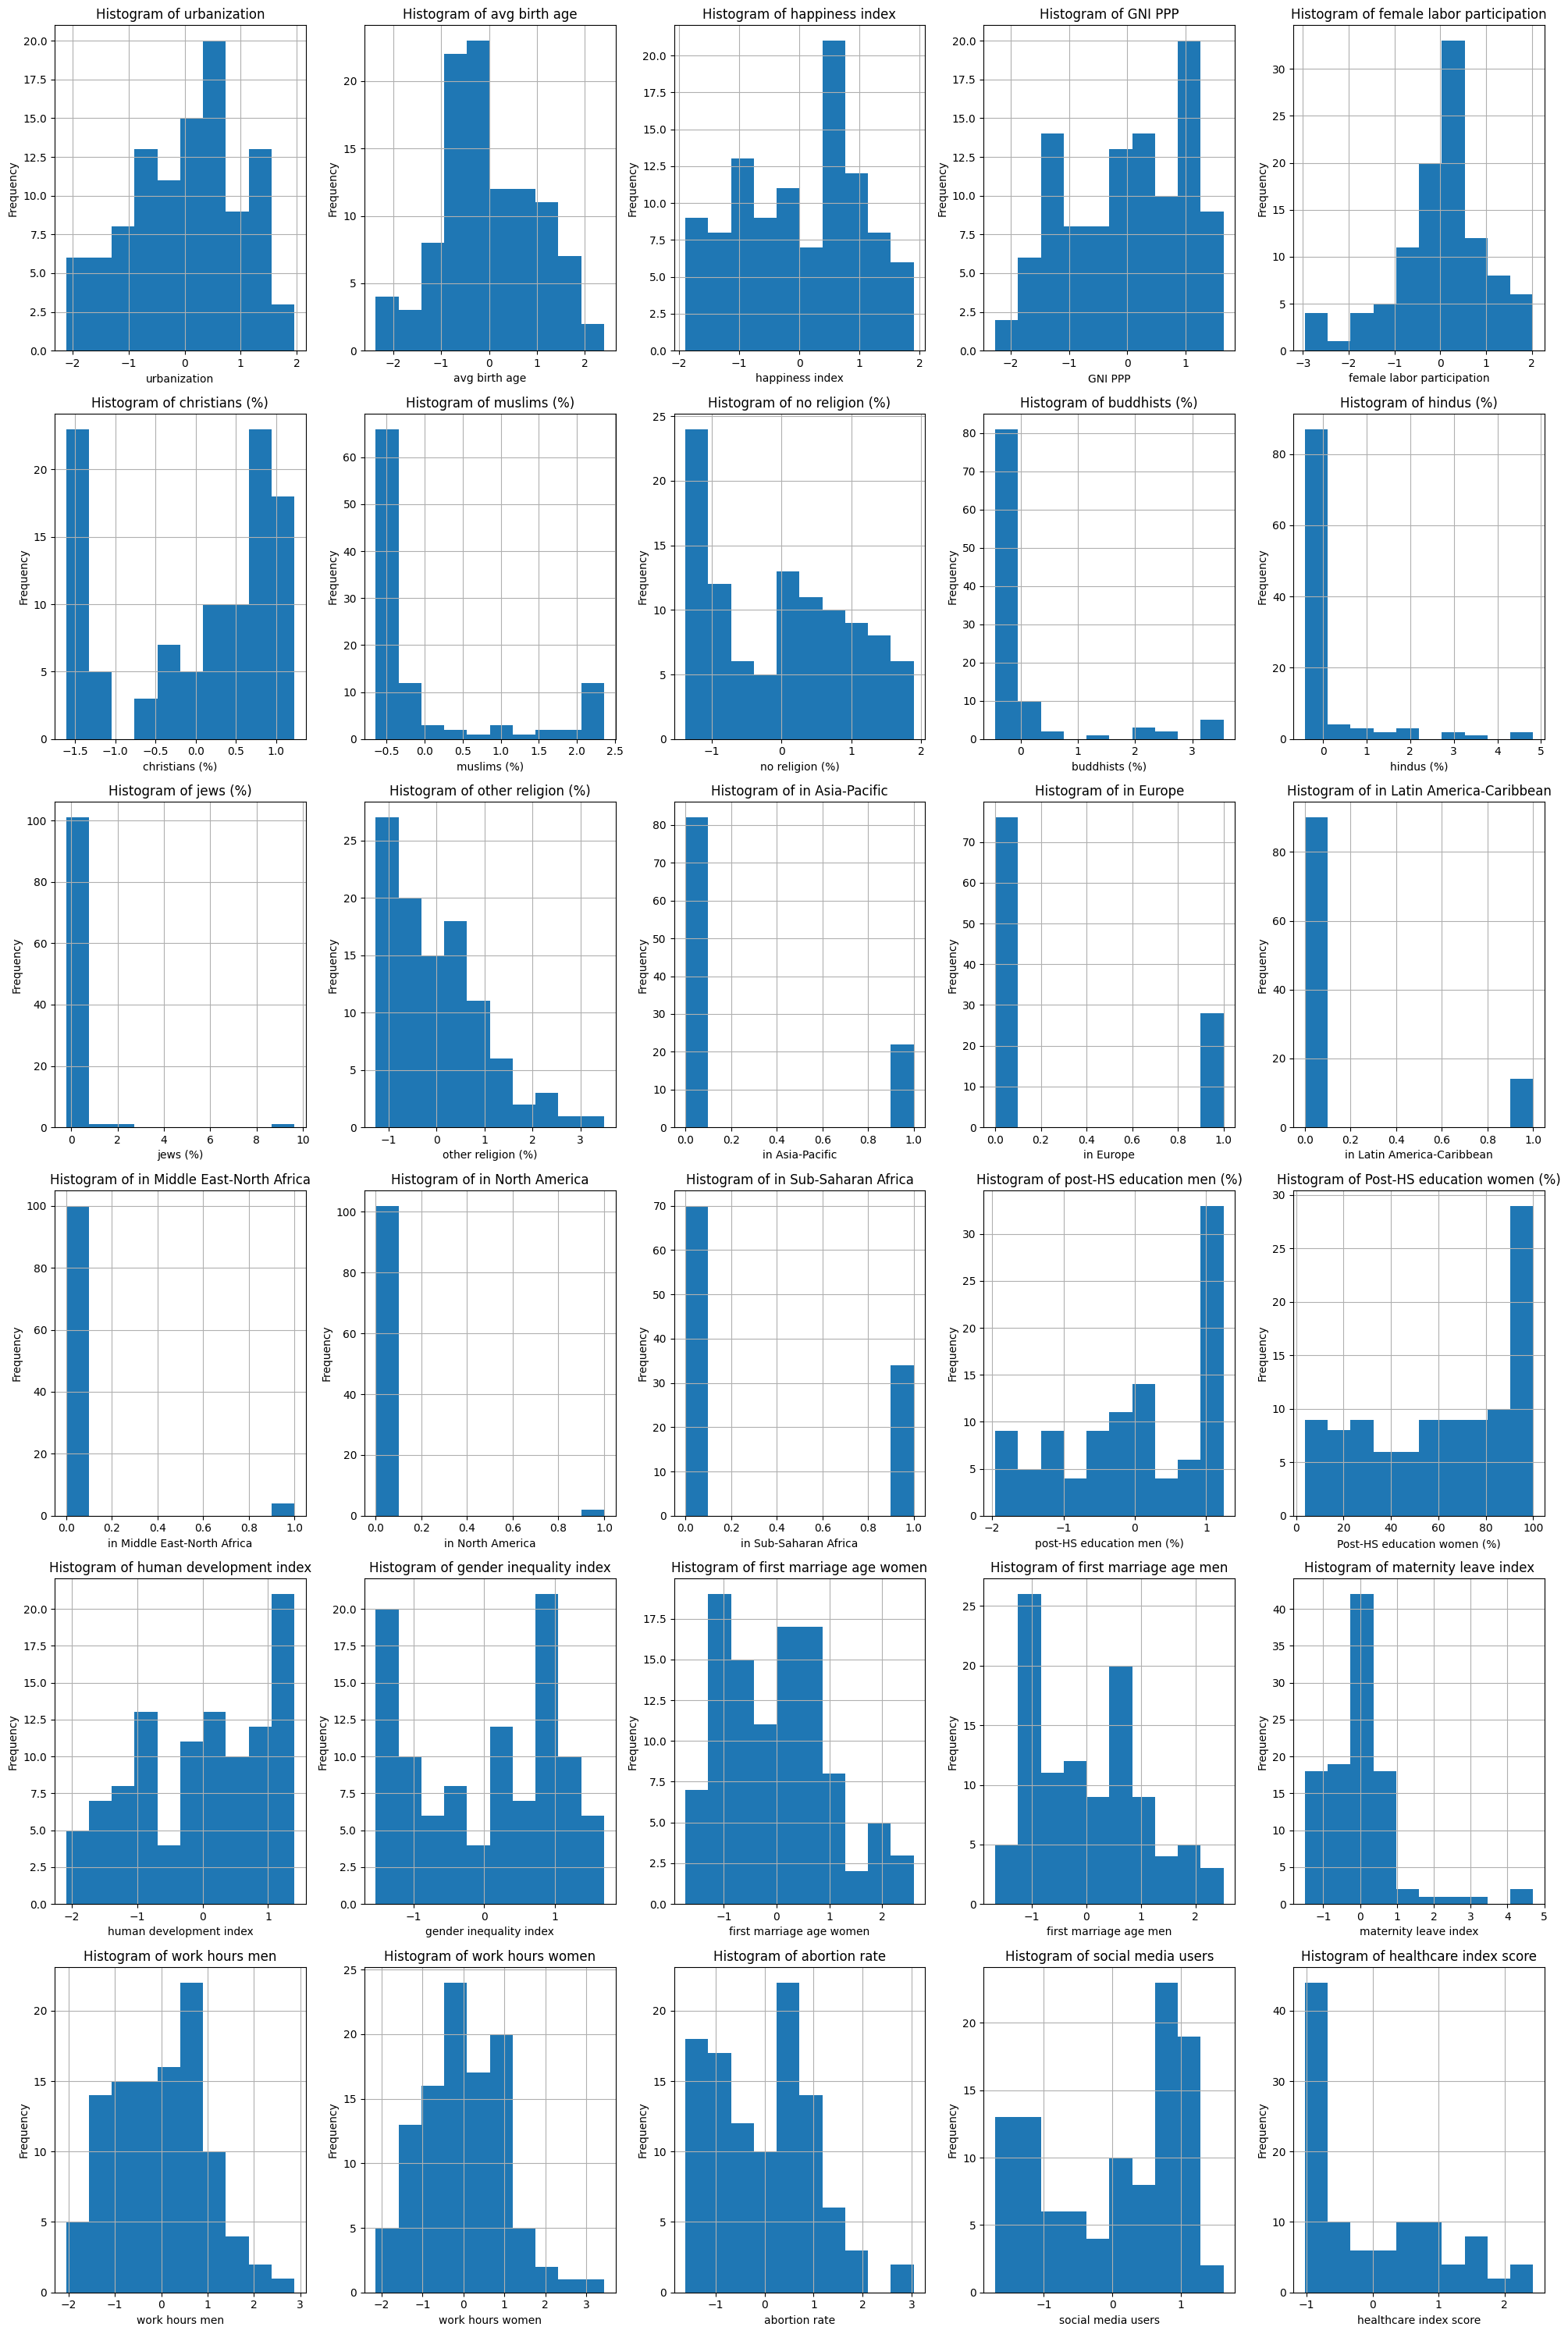


feature pairs correlations:


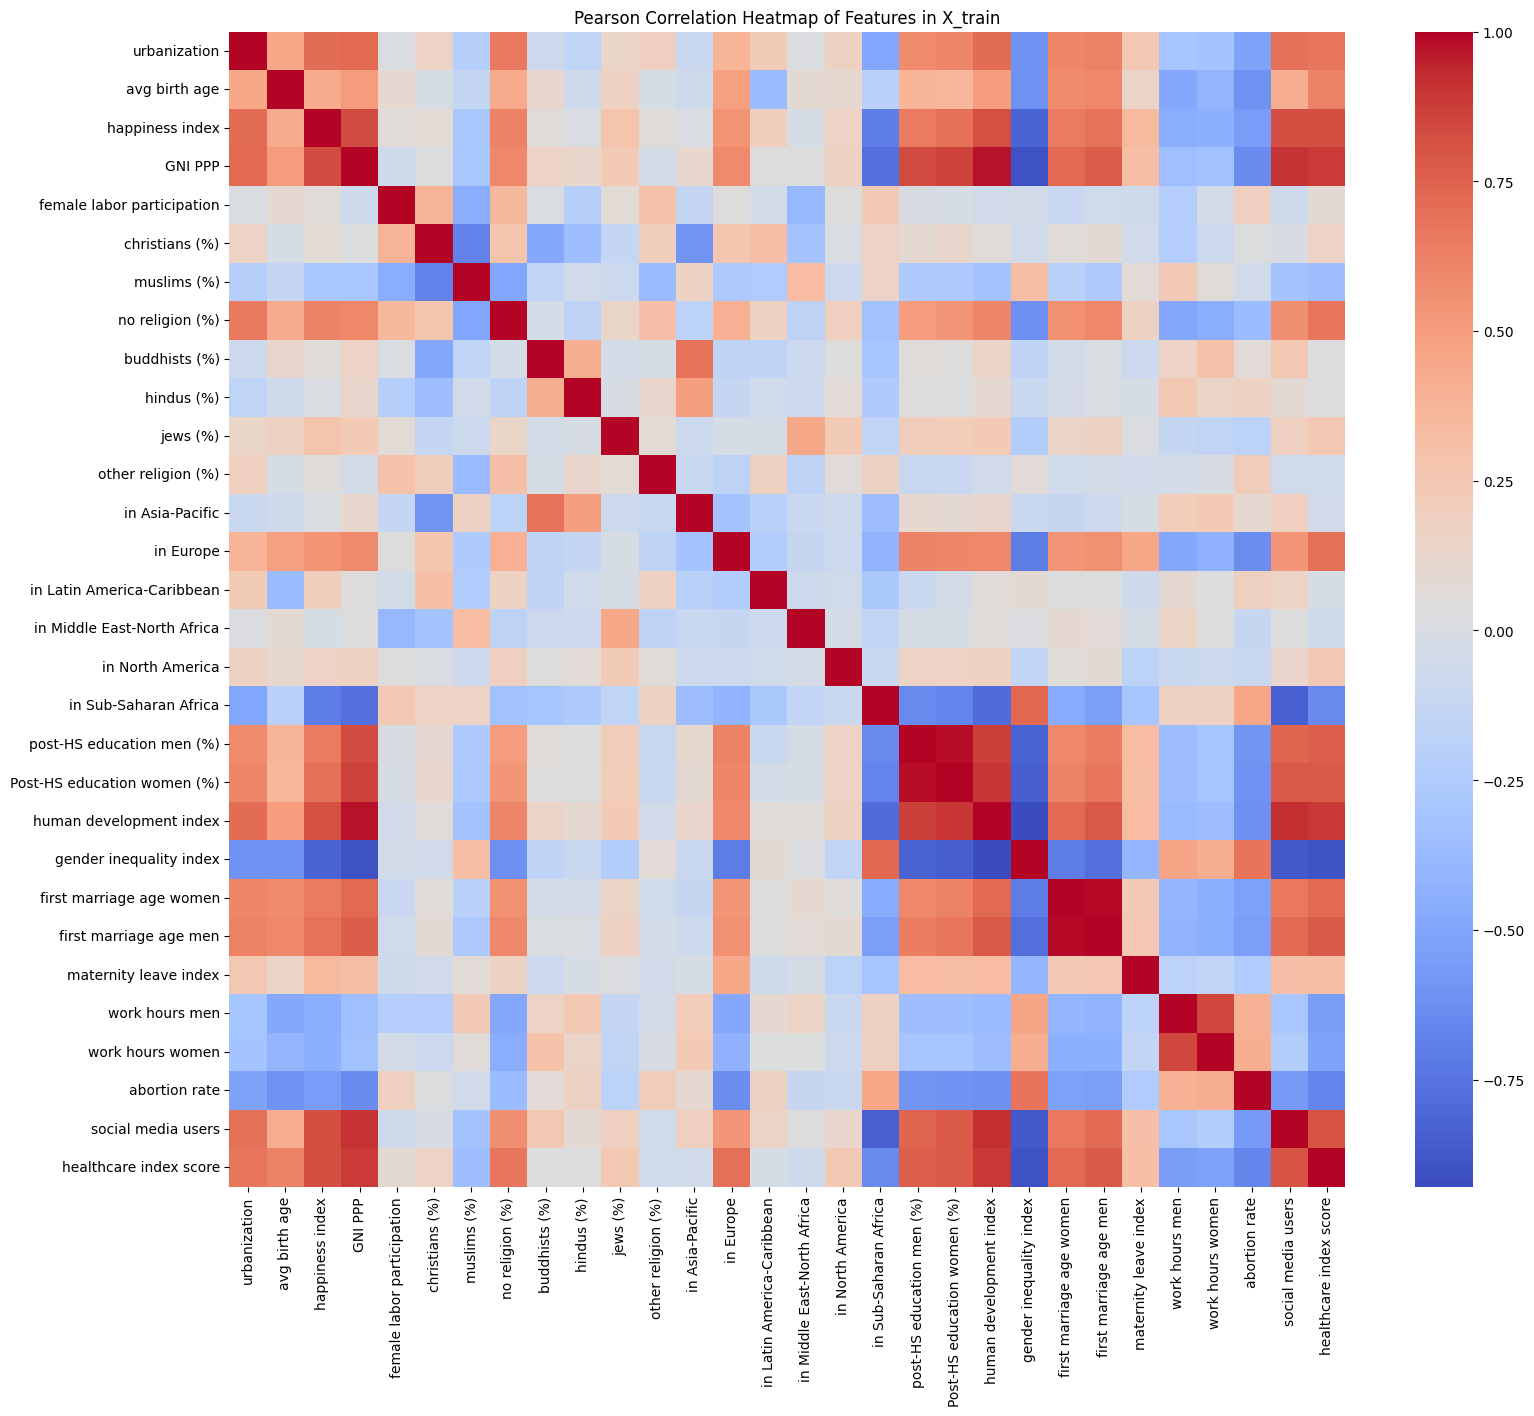


Top 5 most highly correlated pairs of features (absolute Pearson correlation):
  first marriage age women and first marriage age men: 0.9888
  post-HS education men (%) and Post-HS education women (%): 0.9811
  GNI PPP and human development index: 0.9754
  human development index and gender inequality index: -0.9283
  human development index and social media users: 0.9166


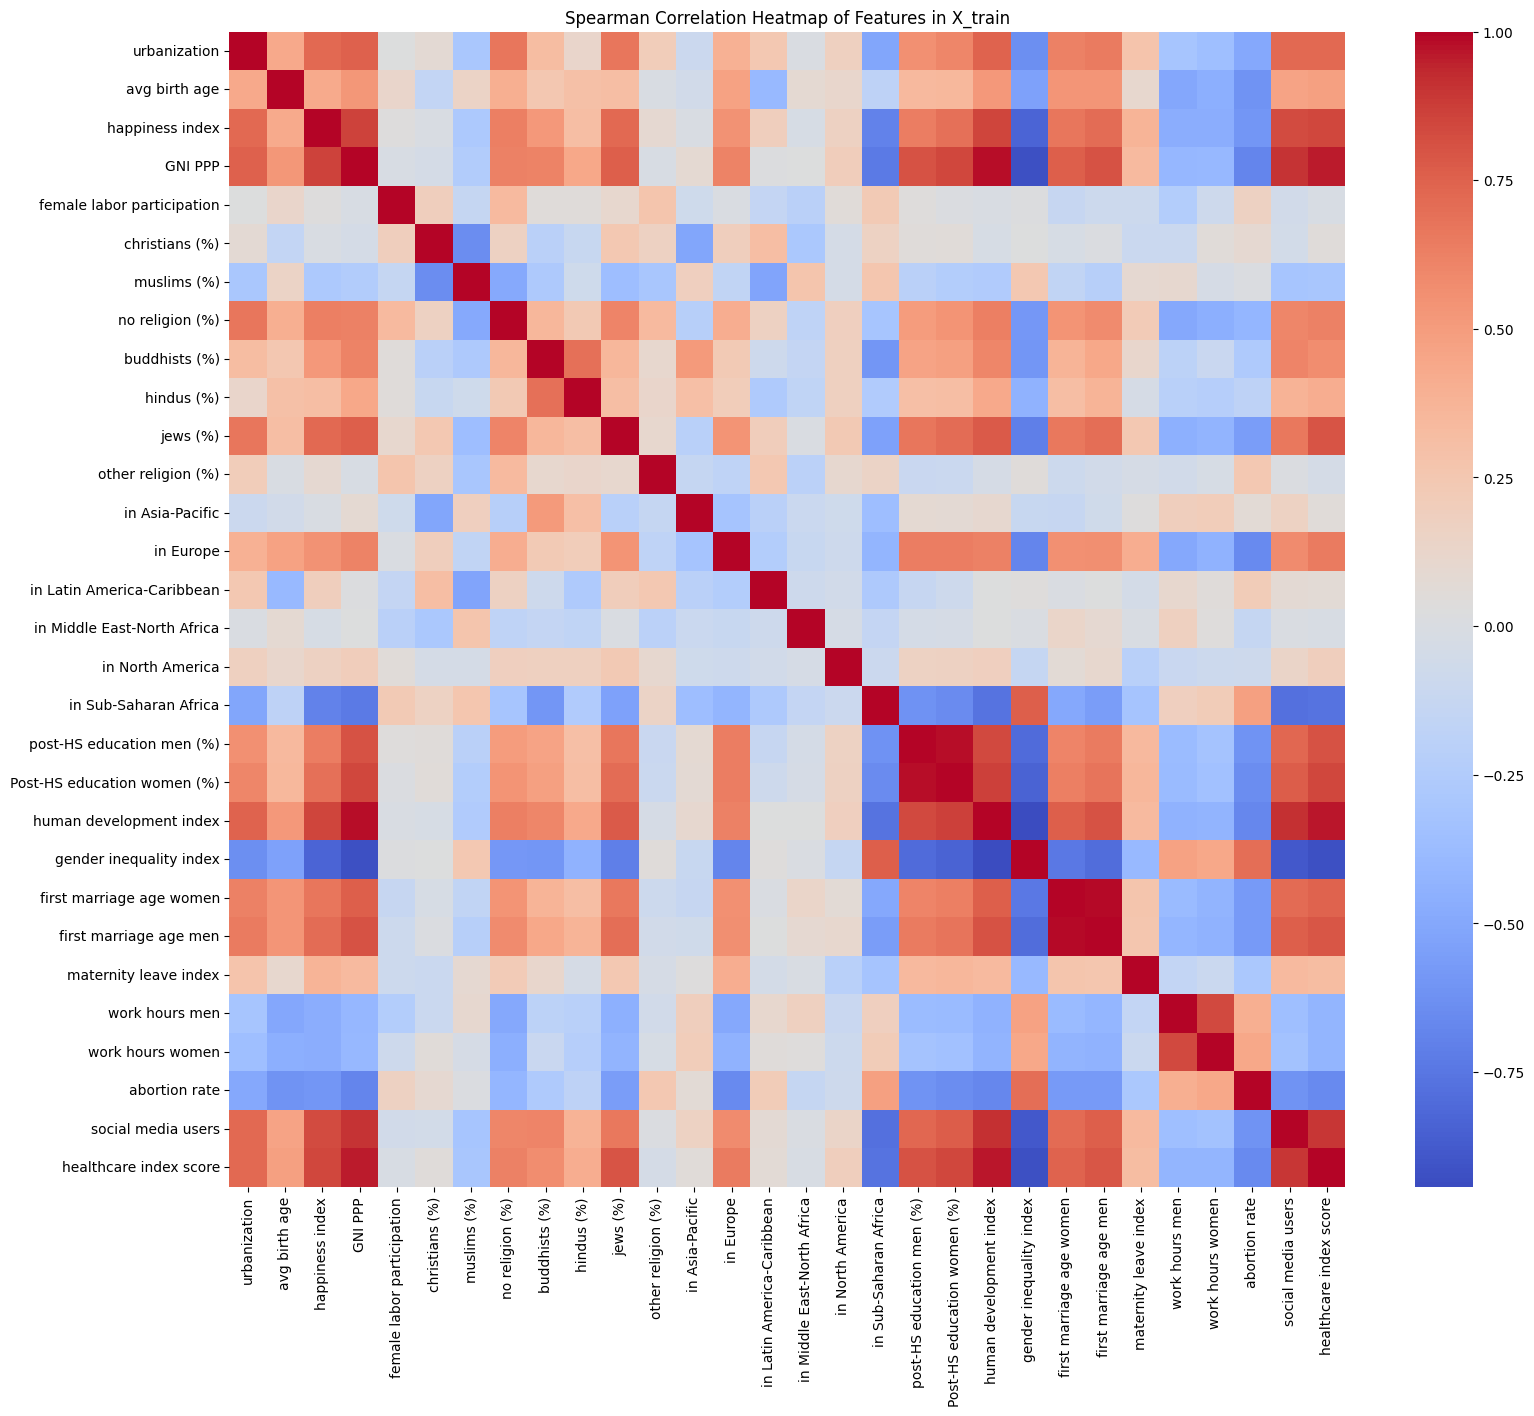


Top 5 most highly correlated pairs of features (absolute Spearman correlation):
  first marriage age women and first marriage age men: 0.9851
  post-HS education men (%) and Post-HS education women (%): 0.9822
  GNI PPP and human development index: 0.9821
  human development index and healthcare index score: 0.9683
  GNI PPP and healthcare index score: 0.9578


/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


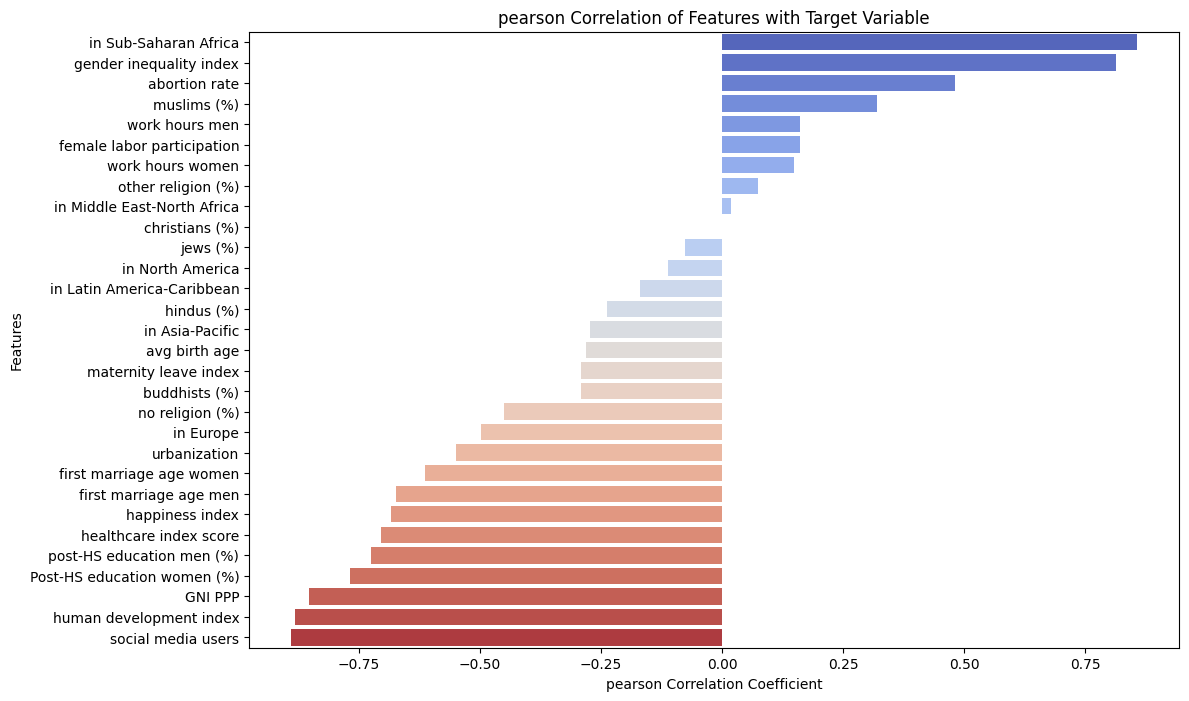


pearson Correlation with Target:
in Sub-Saharan Africa          0.856788
gender inequality index        0.814912
abortion rate                  0.481189
muslims (%)                    0.321094
work hours men                 0.160676
female labor participation     0.160287
work hours women               0.149026
other religion (%)             0.074008
in Middle East-North Africa    0.019418
christians (%)                 0.000515
jews (%)                      -0.075971
in North America              -0.111411
in Latin America-Caribbean    -0.170361
hindus (%)                    -0.237167
in Asia-Pacific               -0.273279
avg birth age                 -0.281065
maternity leave index         -0.290619
buddhists (%)                 -0.291736
no religion (%)               -0.449896
in Europe                     -0.497317
urbanization                  -0.548769
first marriage age women      -0.612978
first marriage age men        -0.674392
happiness index               -0.684732
health

/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


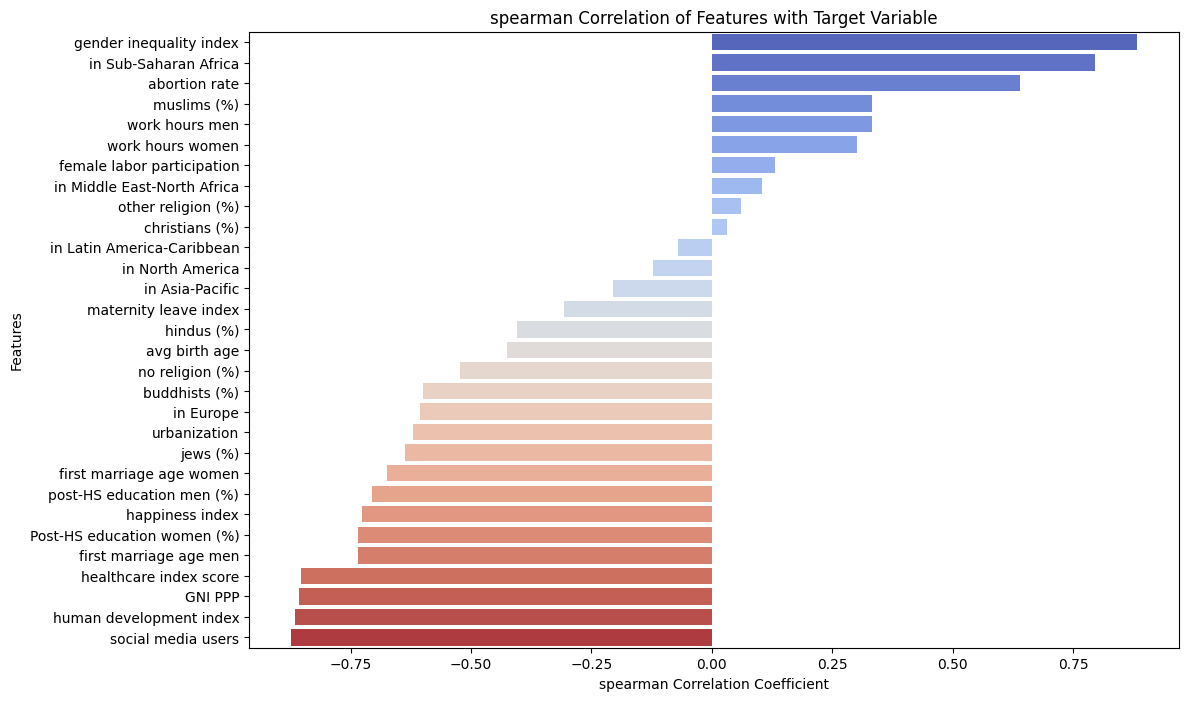


spearman Correlation with Target:
gender inequality index        0.882303
in Sub-Saharan Africa          0.794807
abortion rate                  0.640375
muslims (%)                    0.332363
work hours men                 0.332265
work hours women               0.300760
female labor participation     0.131677
in Middle East-North Africa    0.104932
other religion (%)             0.060858
christians (%)                 0.031758
in Latin America-Caribbean    -0.071322
in North America              -0.122445
in Asia-Pacific               -0.204309
maternity leave index         -0.307832
hindus (%)                    -0.404624
avg birth age                 -0.425574
no religion (%)               -0.522893
buddhists (%)                 -0.600332
in Europe                     -0.605139
urbanization                  -0.619974
jews (%)                      -0.636714
first marriage age women      -0.675069
post-HS education men (%)     -0.706588
happiness index               -0.727373
Post-

/tmp/ipython-input-2867624879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')


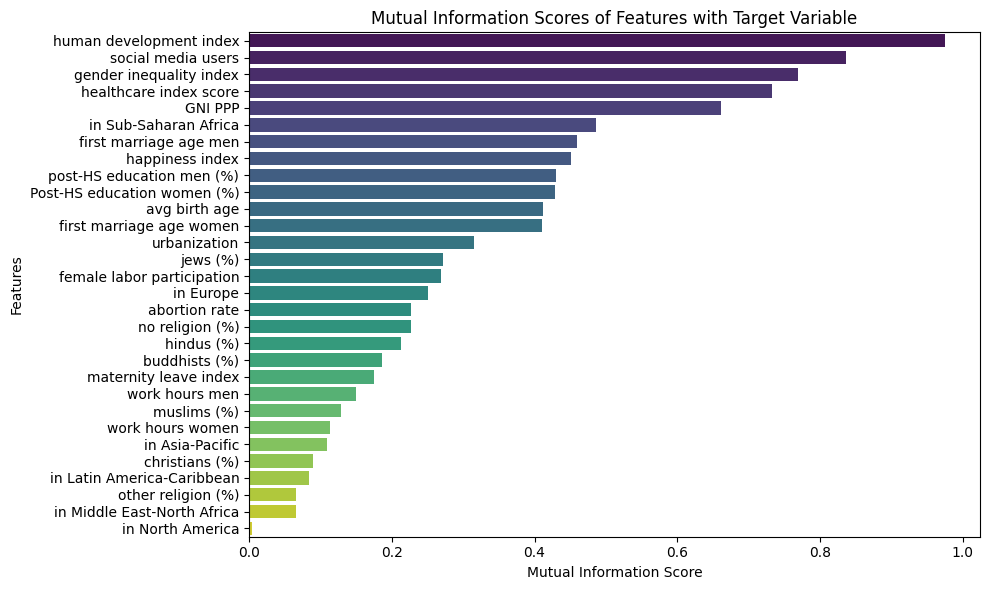


lasso regressor:
Best params: {'lasso__alpha': 0.01}
CV MSE: 0.2841 (±0.5242)
Train accuracy:
MSE: 0.1558

coefficients:
human development index: -0.6816
in Sub-Saharan Africa: 0.5756
social media users: -0.3692
gender inequality index: 0.1996
avg birth age: 0.1535
post-HS education men (%): 0.1477
jews (%): 0.1280
happiness index: 0.1279
first marriage age men: -0.1234
work hours men: -0.1114
muslims (%): 0.0953
urbanization: 0.0787
healthcare index score: 0.0646
buddhists (%): -0.0518
female labor participation: 0.0509
hindus (%): -0.0381
abortion rate: 0.0294
other religion (%): -0.0229
in Middle East-North Africa: 0.0134
no religion (%): 0.0110
Post-HS education women (%): -0.0040
christians (%): -0.0000
in Europe: -0.0000
in Asia-Pacific: -0.0000
GNI PPP: -0.0000
in North America: -0.0000
in Latin America-Caribbean: -0.0000
first marriage age women: -0.0000
maternity leave index: -0.0000
work hours women: -0.0000

ridge regressor:
Best params: {'ridge__alpha': 10}
CV MSE: 0.2716 

/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


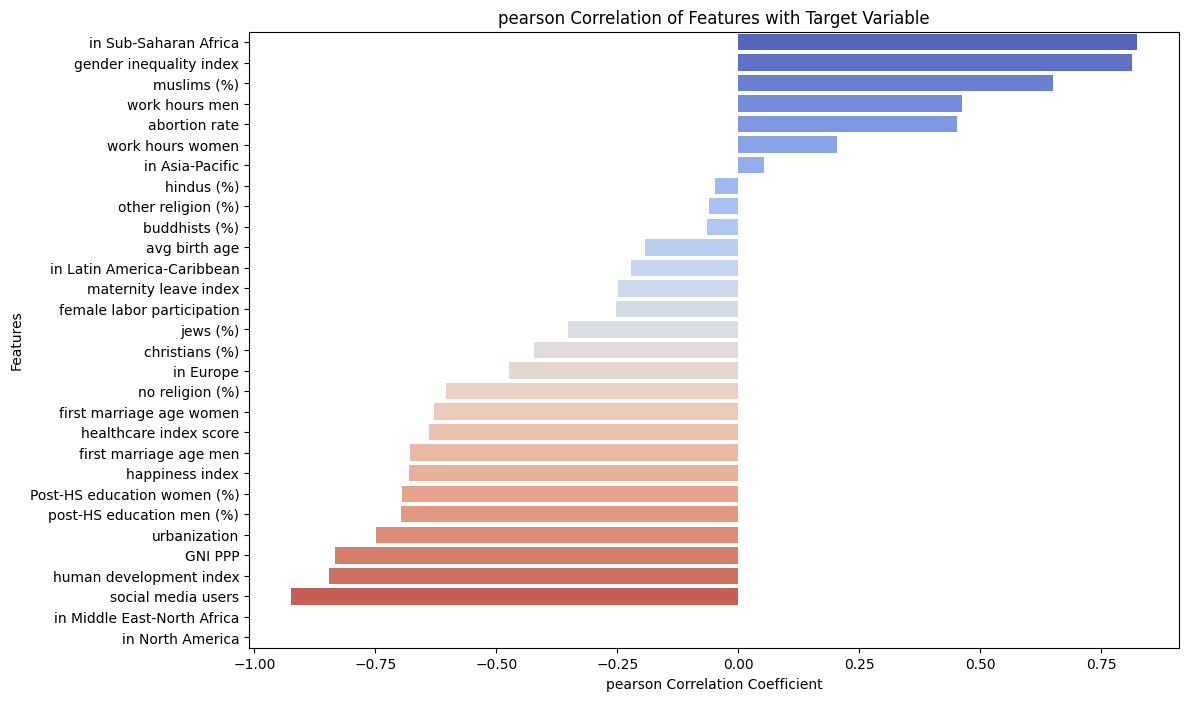


pearson Correlation with Target:
in Sub-Saharan Africa          0.823179
gender inequality index        0.812352
muslims (%)                    0.649306
work hours men                 0.462830
abortion rate                  0.452339
work hours women               0.203023
in Asia-Pacific                0.052335
hindus (%)                    -0.047746
other religion (%)            -0.060001
buddhists (%)                 -0.064822
avg birth age                 -0.192350
in Latin America-Caribbean    -0.222523
maternity leave index         -0.249138
female labor participation    -0.252502
jews (%)                      -0.352532
christians (%)                -0.422458
in Europe                     -0.474789
no religion (%)               -0.603451
first marriage age women      -0.629571
healthcare index score        -0.639214
first marriage age men        -0.679124
happiness index               -0.679423
Post-HS education women (%)   -0.695747
post-HS education men (%)     -0.695863
urbani

/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


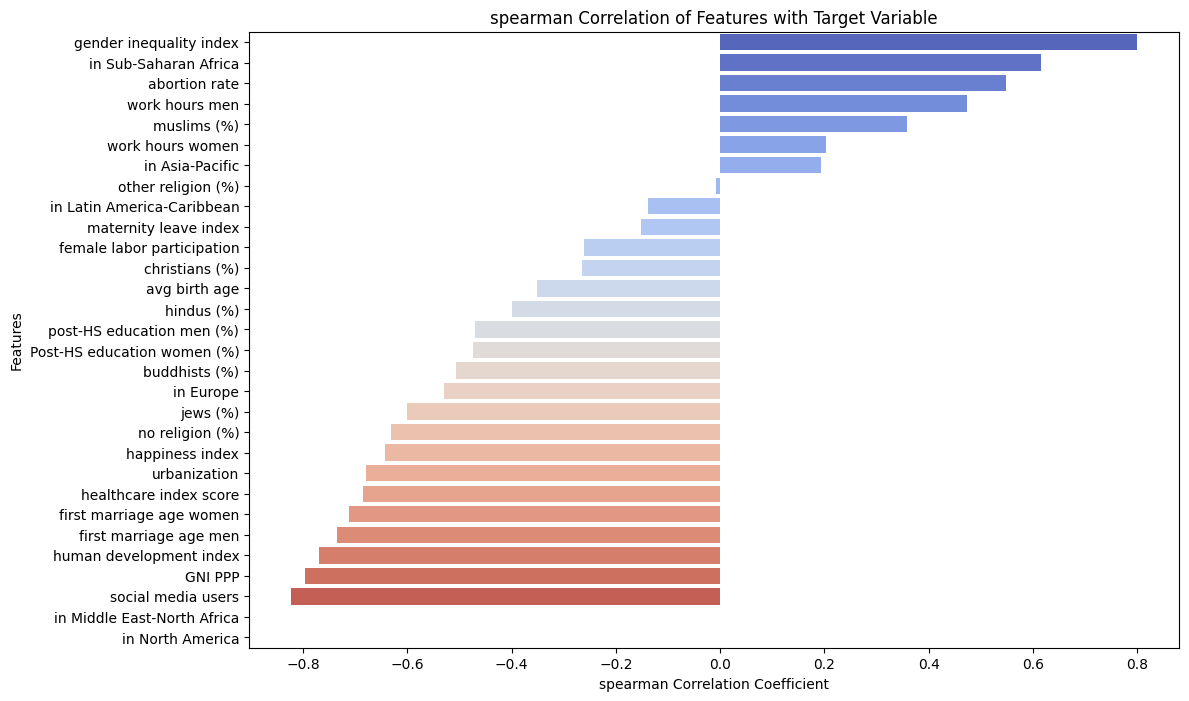


spearman Correlation with Target:
gender inequality index        0.799175
in Sub-Saharan Africa          0.616010
abortion rate                  0.548190
work hours men                 0.474271
muslims (%)                    0.359444
work hours women               0.202505
in Asia-Pacific                0.192741
other religion (%)            -0.007024
in Latin America-Caribbean    -0.137316
maternity leave index         -0.150811
female labor participation    -0.261414
christians (%)                -0.264468
avg birth age                 -0.351199
hindus (%)                    -0.400061
post-HS education men (%)     -0.470606
Post-HS education women (%)   -0.473049
buddhists (%)                 -0.506720
in Europe                     -0.529817
jews (%)                      -0.600245
no religion (%)               -0.631547
happiness index               -0.643457
urbanization                  -0.678272
healthcare index score        -0.685296
first marriage age women      -0.712082
first

/tmp/ipython-input-2867624879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')


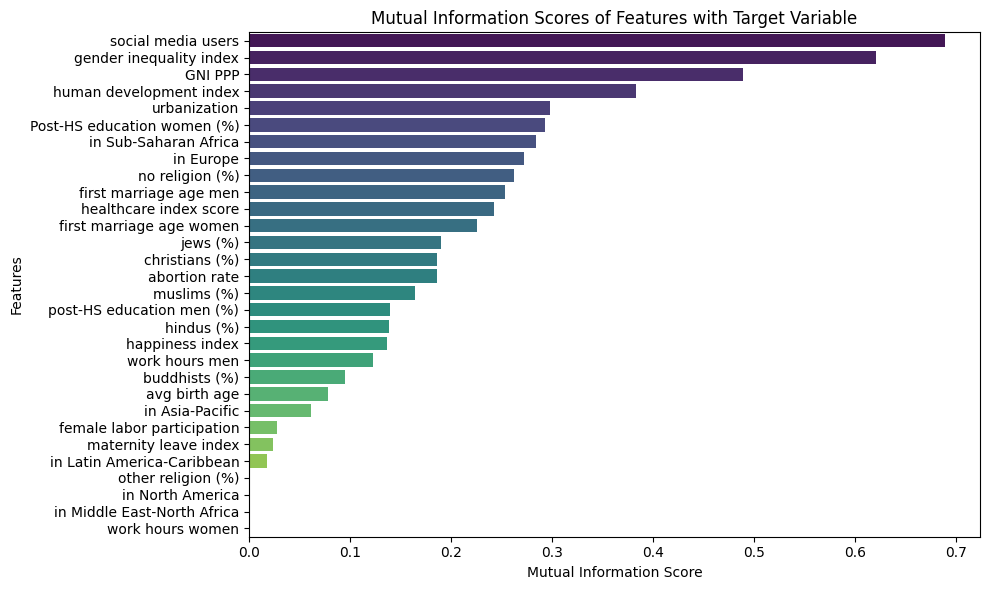

testing trained models signal strength using test set:

lasso regressor final results:
MSE: 0.1543
For: ('China', 2023), Actual: 0.9990, Predicted: 1.4490
For: ('Malta', 2023), Actual: 1.0600, Predicted: 1.6287
For: ('Chile', 2023), Actual: 1.1670, Predicted: 1.3102
For: ('Jamaica', 2023), Actual: 1.3580, Predicted: 1.8996
For: ('Russian Federation', 2023), Actual: 1.4100, Predicted: 1.6092
For: ('Sweden', 2023), Actual: 1.4500, Predicted: 1.3568
For: ('Czechia', 2023), Actual: 1.4500, Predicted: 1.3847
For: ('Belgium', 2023), Actual: 1.4700, Predicted: 1.3411
For: ('North Macedonia', 2023), Actual: 1.5000, Predicted: 1.8476
For: ('Hungary', 2023), Actual: 1.5100, Predicted: 1.5165

ridge regressor final results:
MSE: 0.1897
For: ('China', 2023), Actual: 0.9990, Predicted: 1.5224
For: ('Malta', 2023), Actual: 1.0600, Predicted: 1.6559
For: ('Chile', 2023), Actual: 1.1670, Predicted: 1.2313
For: ('Jamaica', 2023), Actual: 1.3580, Predicted: 1.8662
For: ('Russian Federation', 2023), Actu

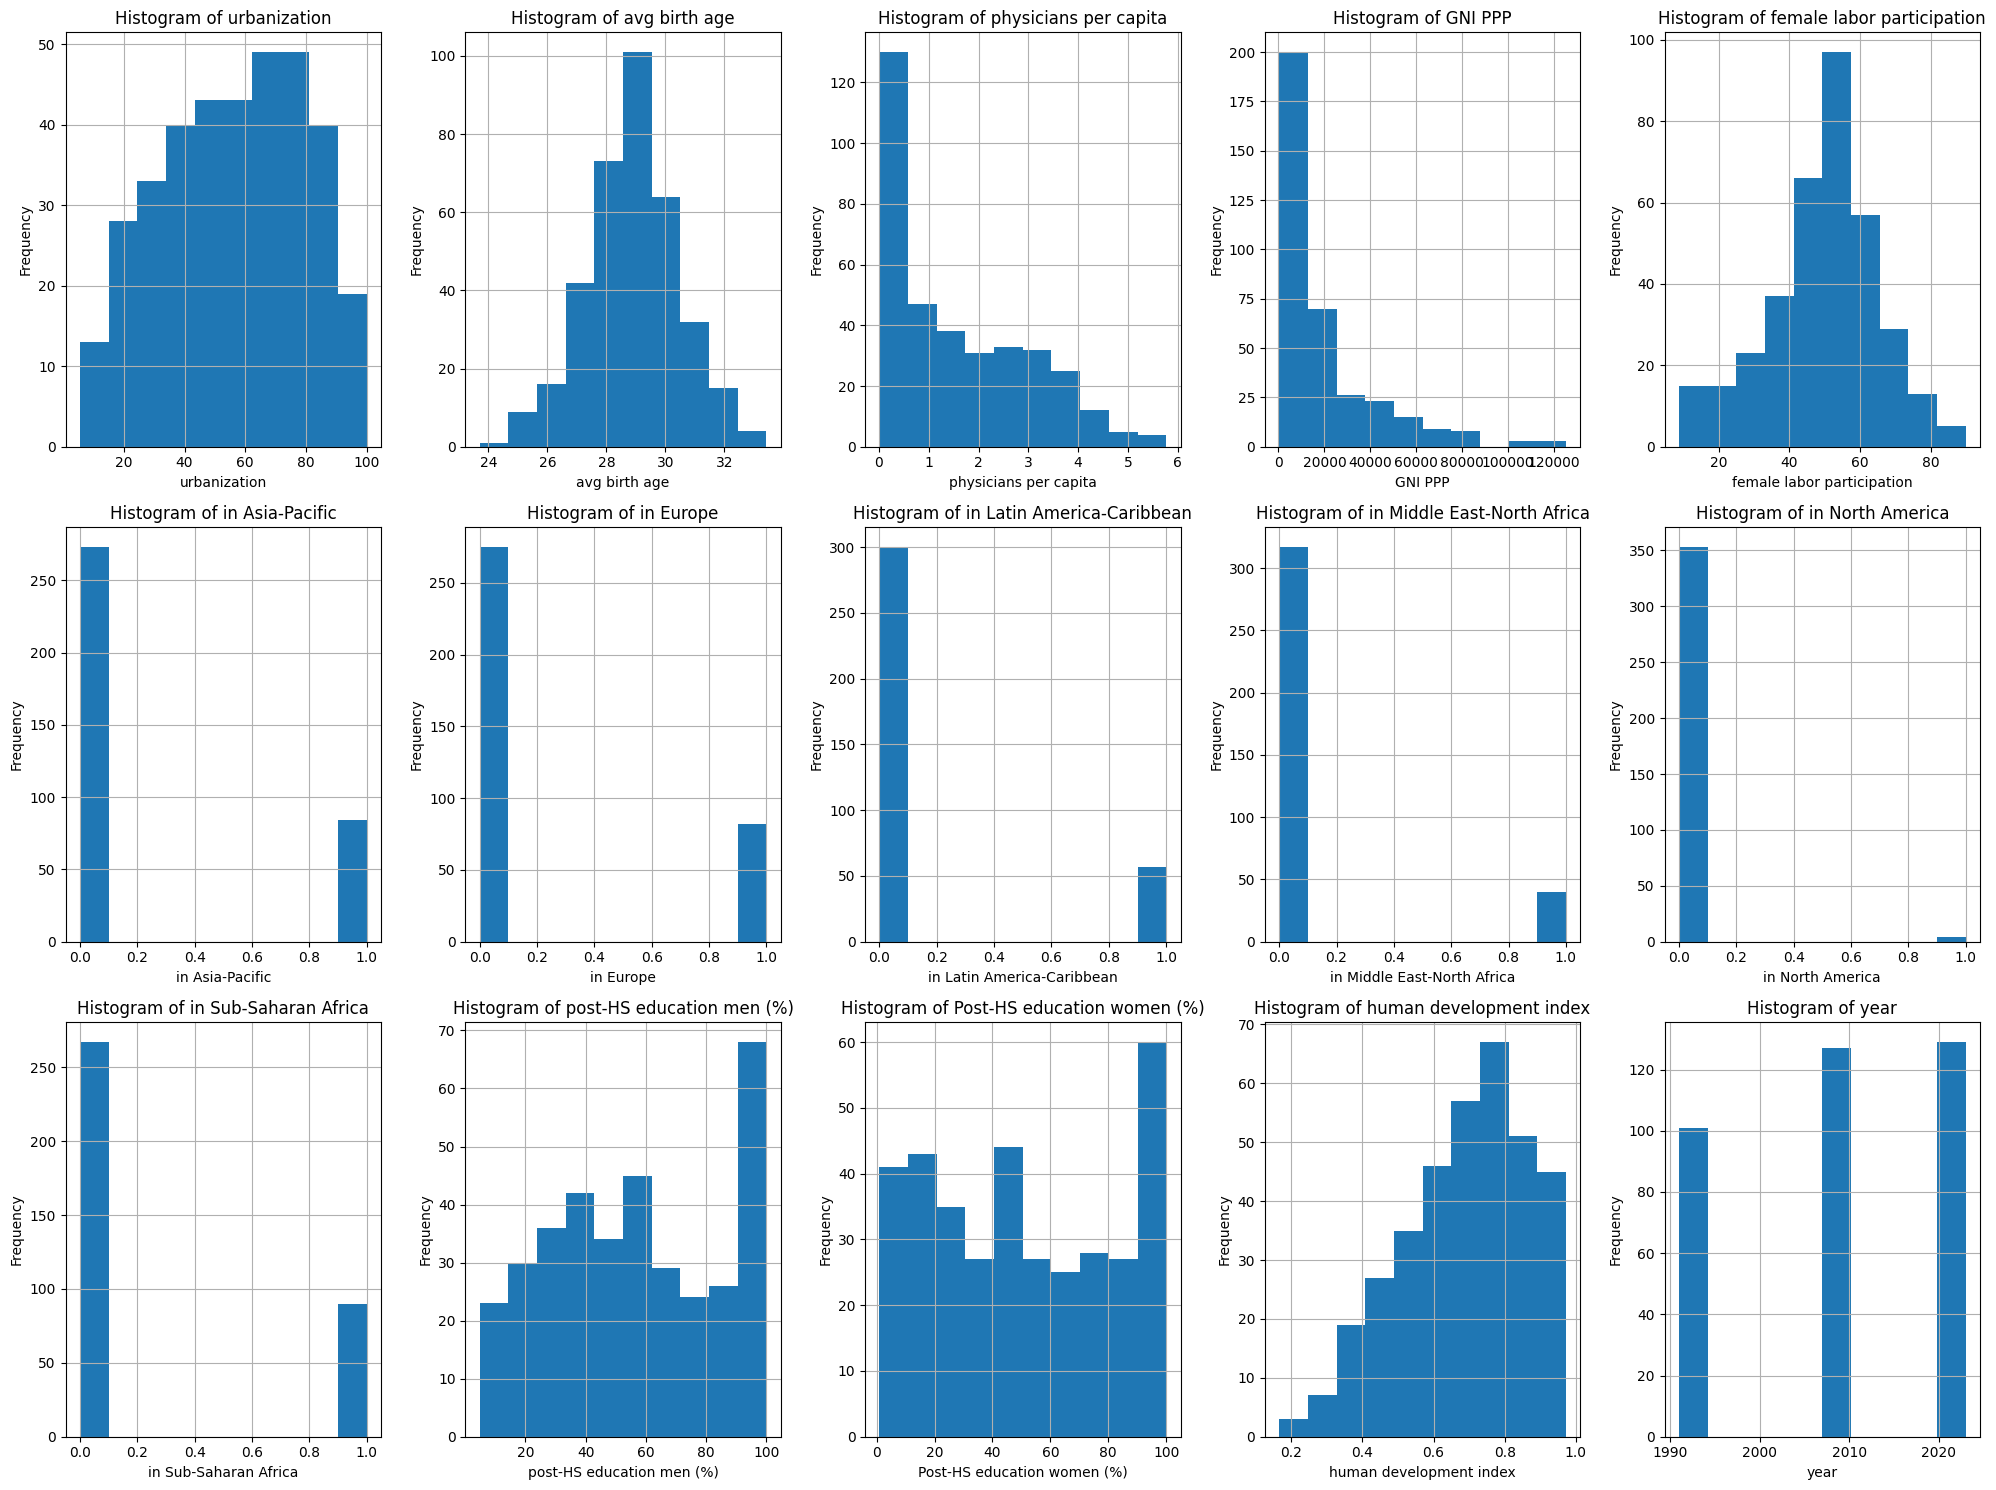

scaled features


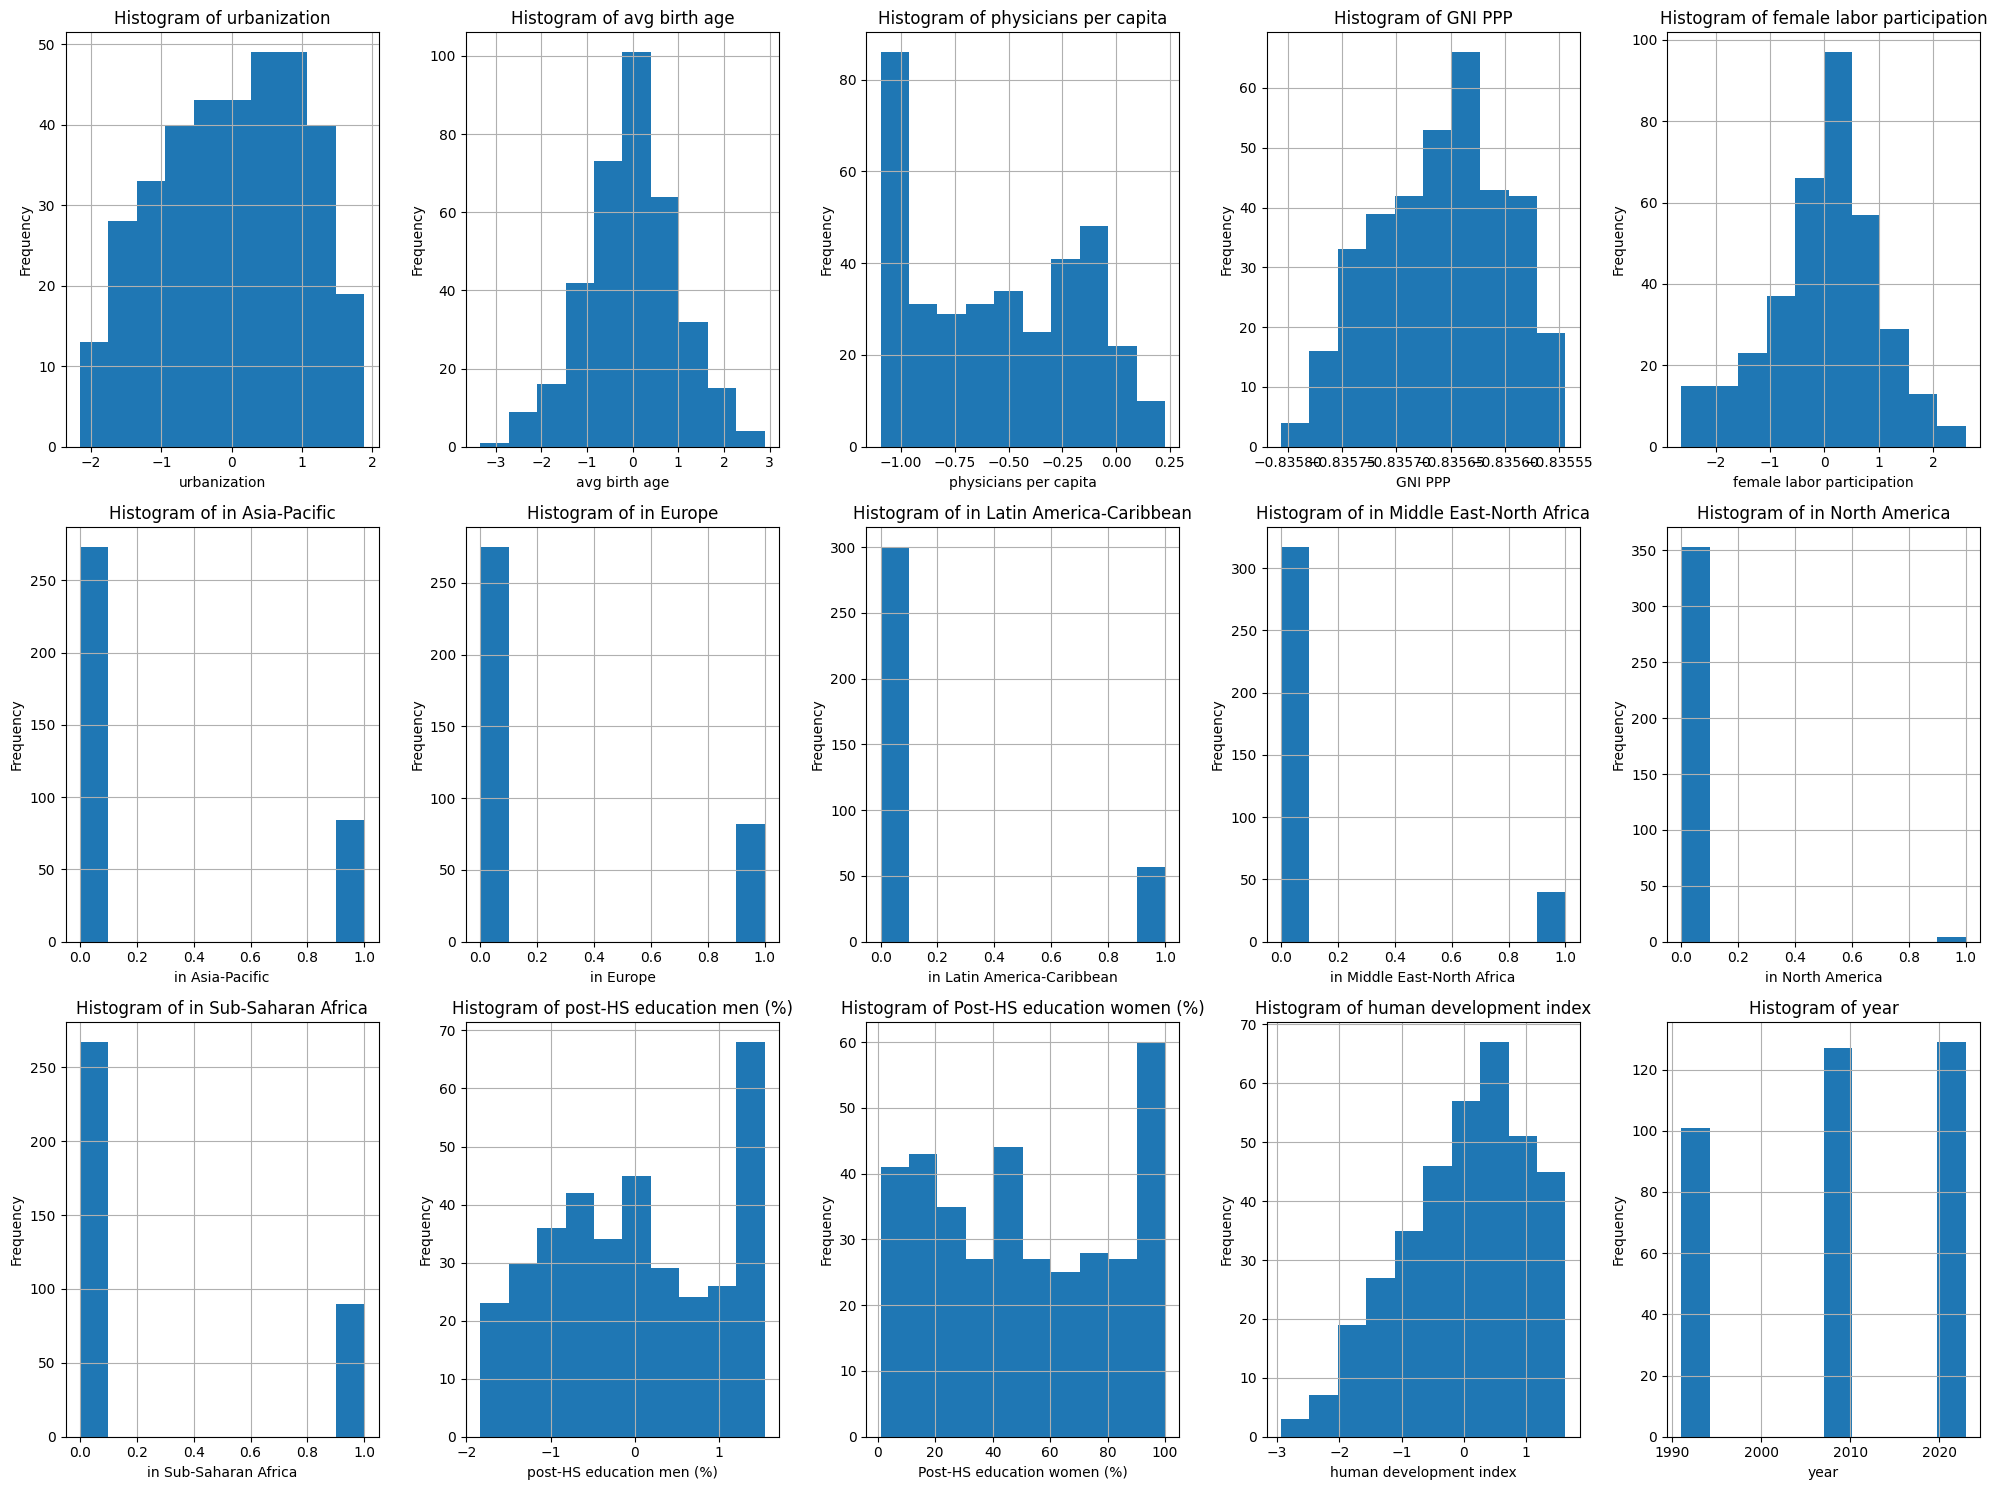


feature pairs correlations:


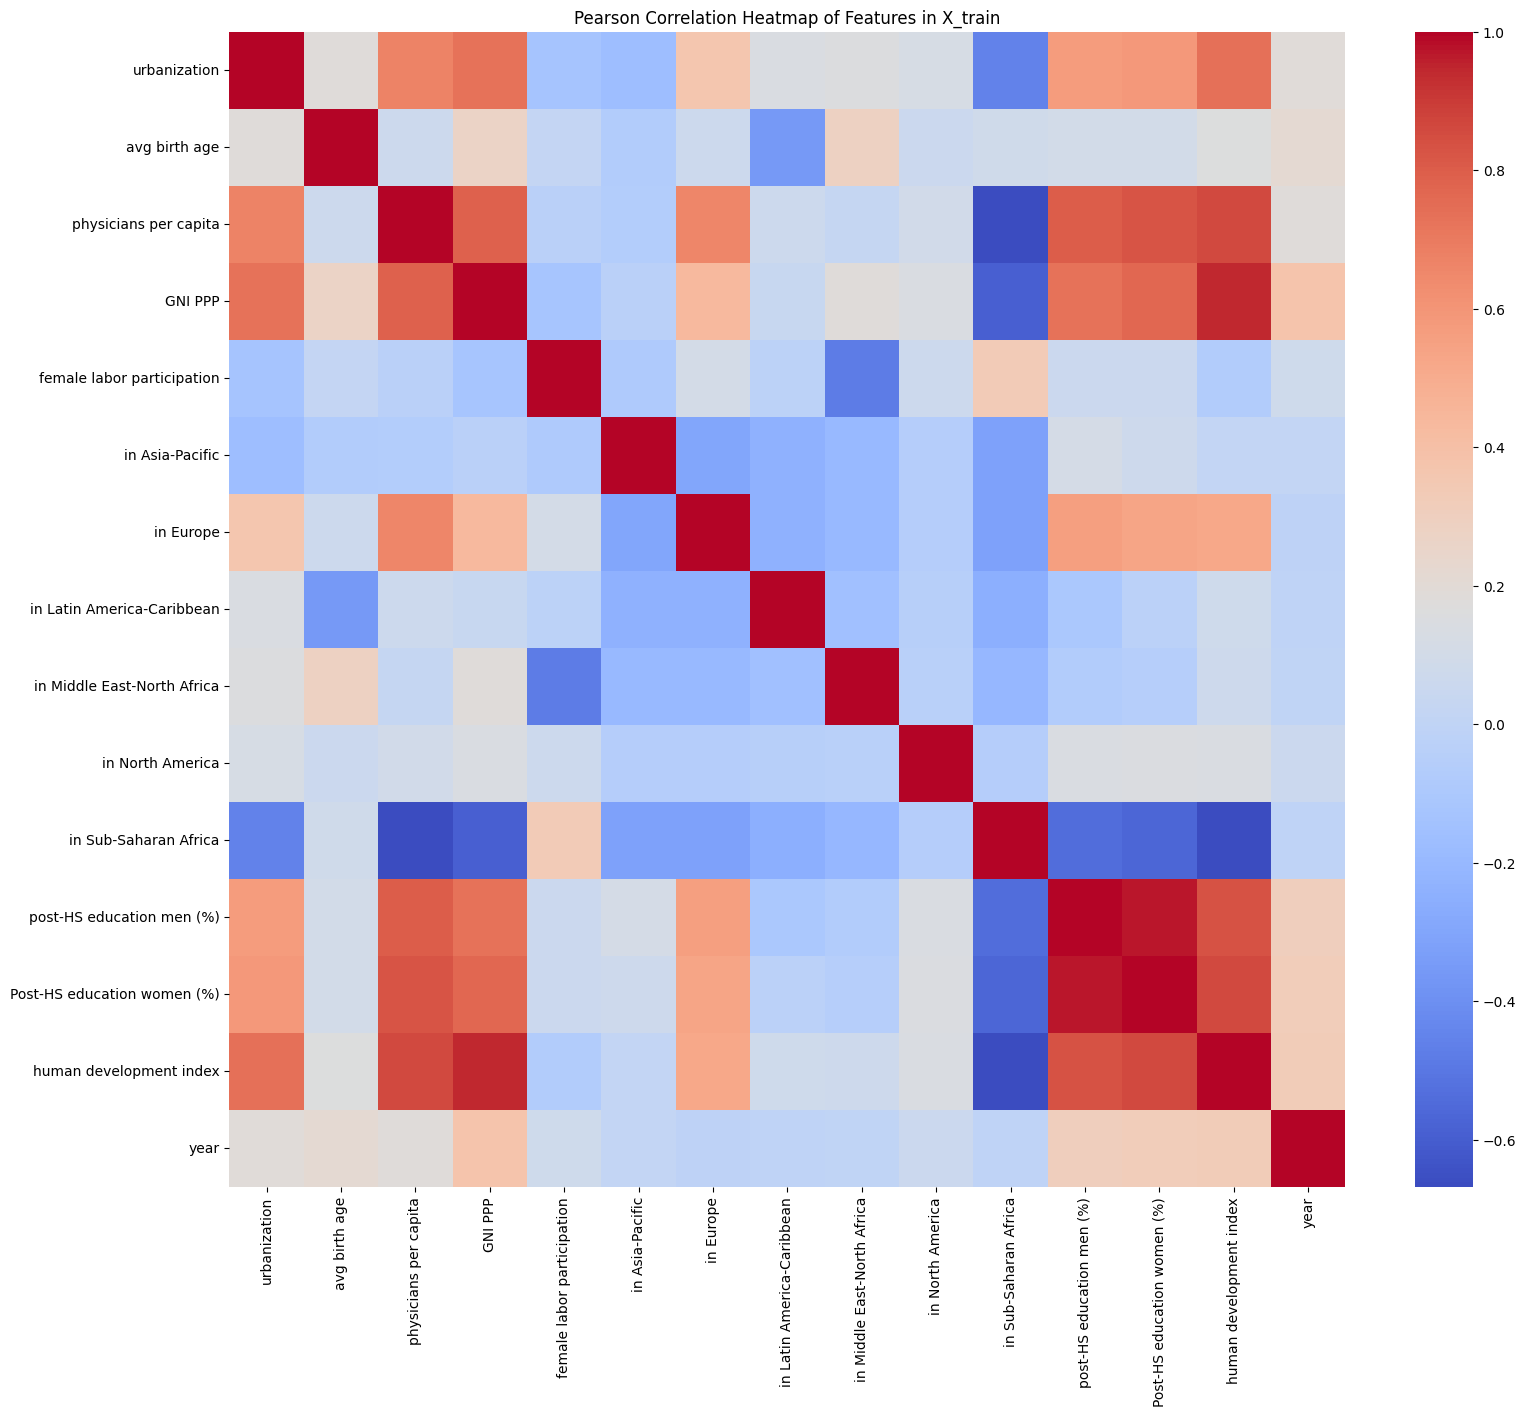


Top 5 most highly correlated pairs of features (absolute Pearson correlation):
  post-HS education men (%) and Post-HS education women (%): 0.9720
  GNI PPP and human development index: 0.9415
  physicians per capita and human development index: 0.8589
  Post-HS education women (%) and human development index: 0.8587
  post-HS education men (%) and human development index: 0.8332


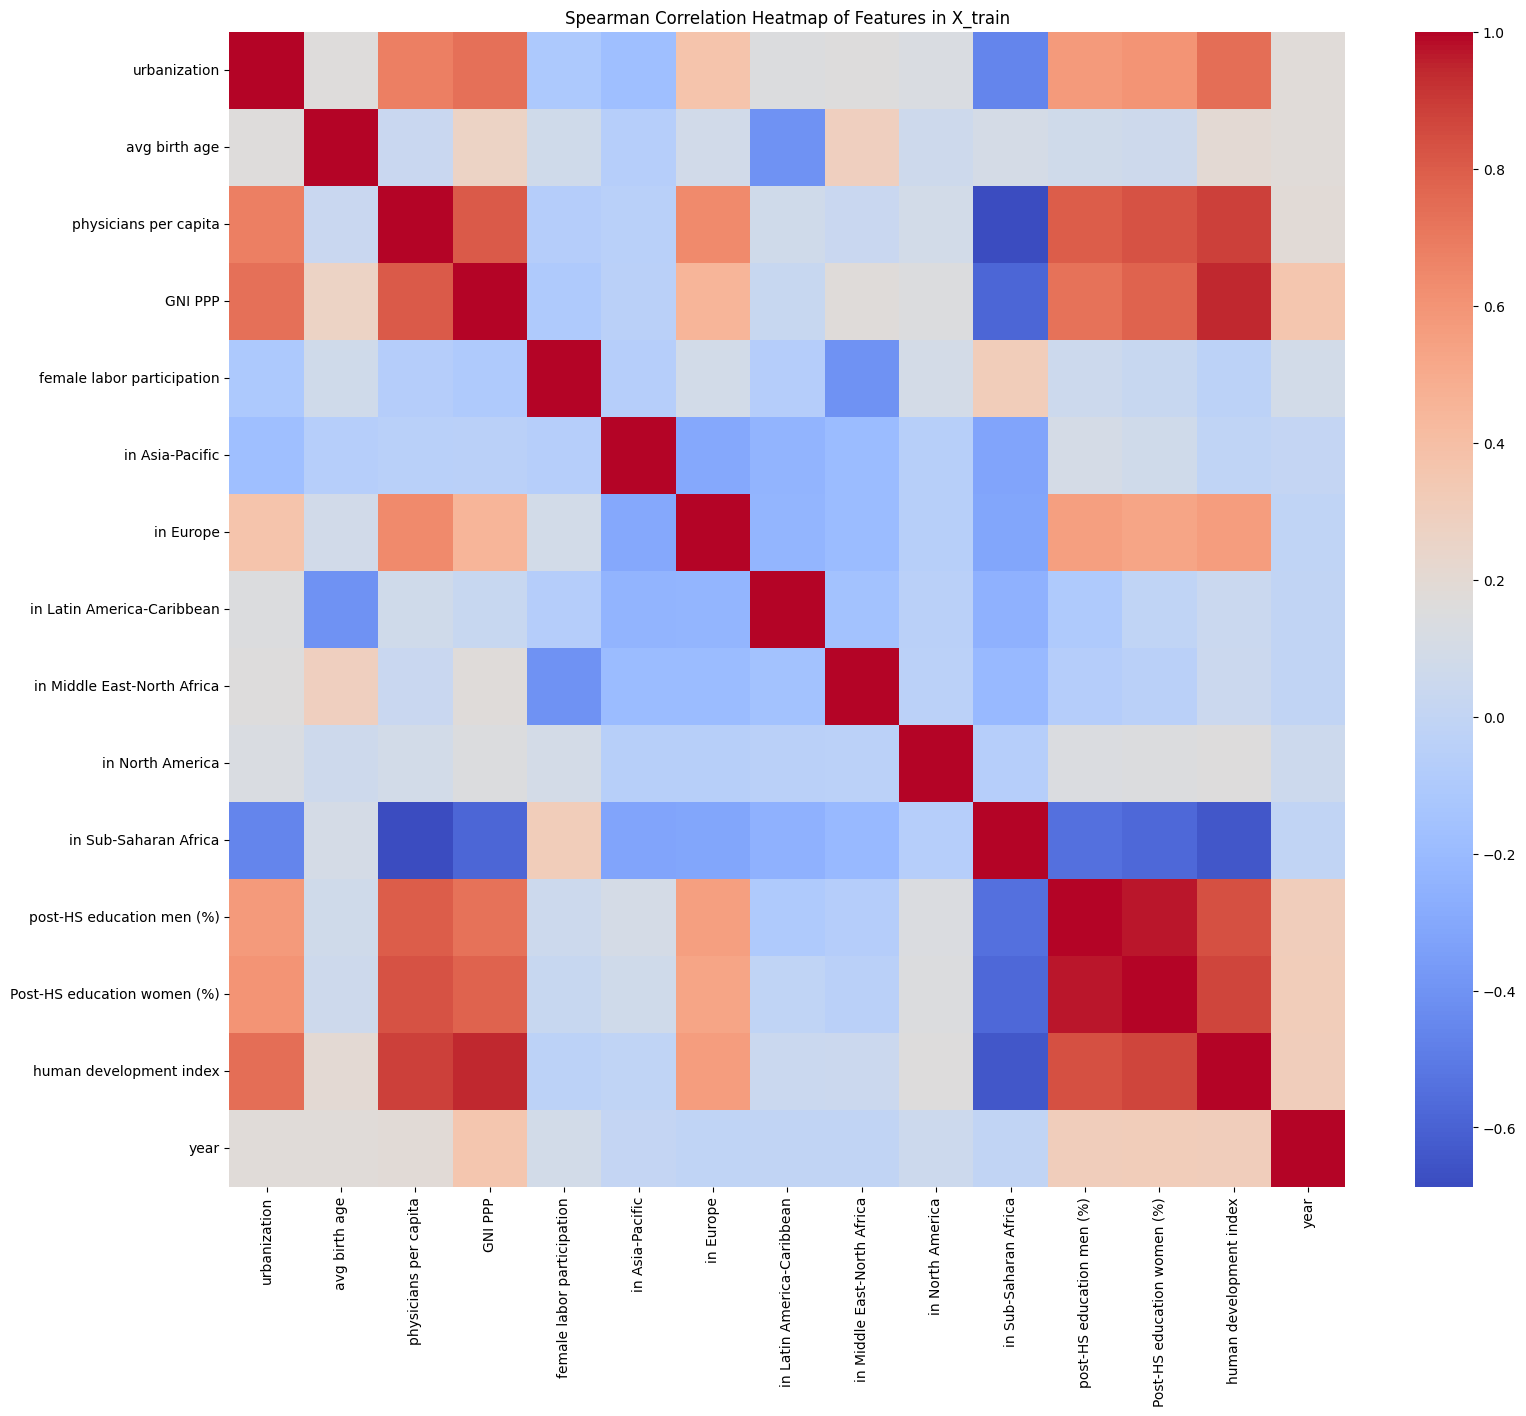


Top 5 most highly correlated pairs of features (absolute Spearman correlation):
  post-HS education men (%) and Post-HS education women (%): 0.9708
  GNI PPP and human development index: 0.9461
  physicians per capita and human development index: 0.8838
  Post-HS education women (%) and human development index: 0.8724
  post-HS education men (%) and human development index: 0.8354


/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


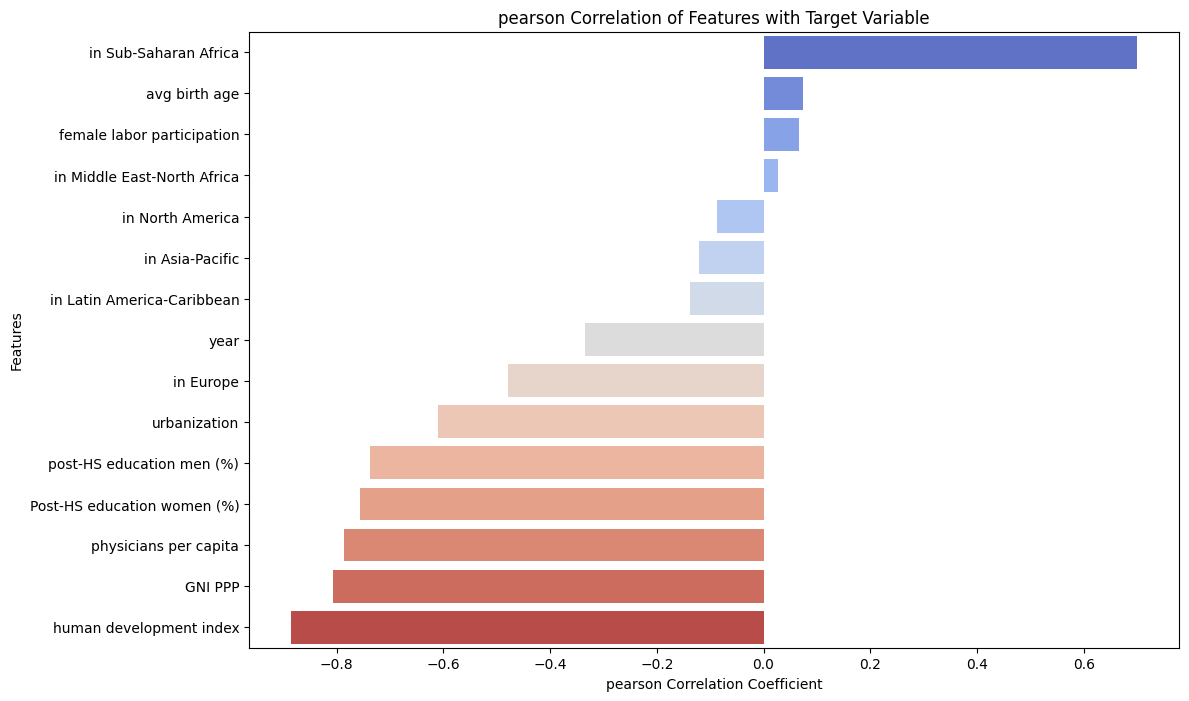


pearson Correlation with Target:
in Sub-Saharan Africa          0.699444
avg birth age                  0.074120
female labor participation     0.067285
in Middle East-North Africa    0.026504
in North America              -0.087969
in Asia-Pacific               -0.120257
in Latin America-Caribbean    -0.137588
year                          -0.334151
in Europe                     -0.478809
urbanization                  -0.610042
post-HS education men (%)     -0.737349
Post-HS education women (%)   -0.756793
physicians per capita         -0.785662
GNI PPP                       -0.806464
human development index       -0.884926
Name: target, dtype: float64


/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


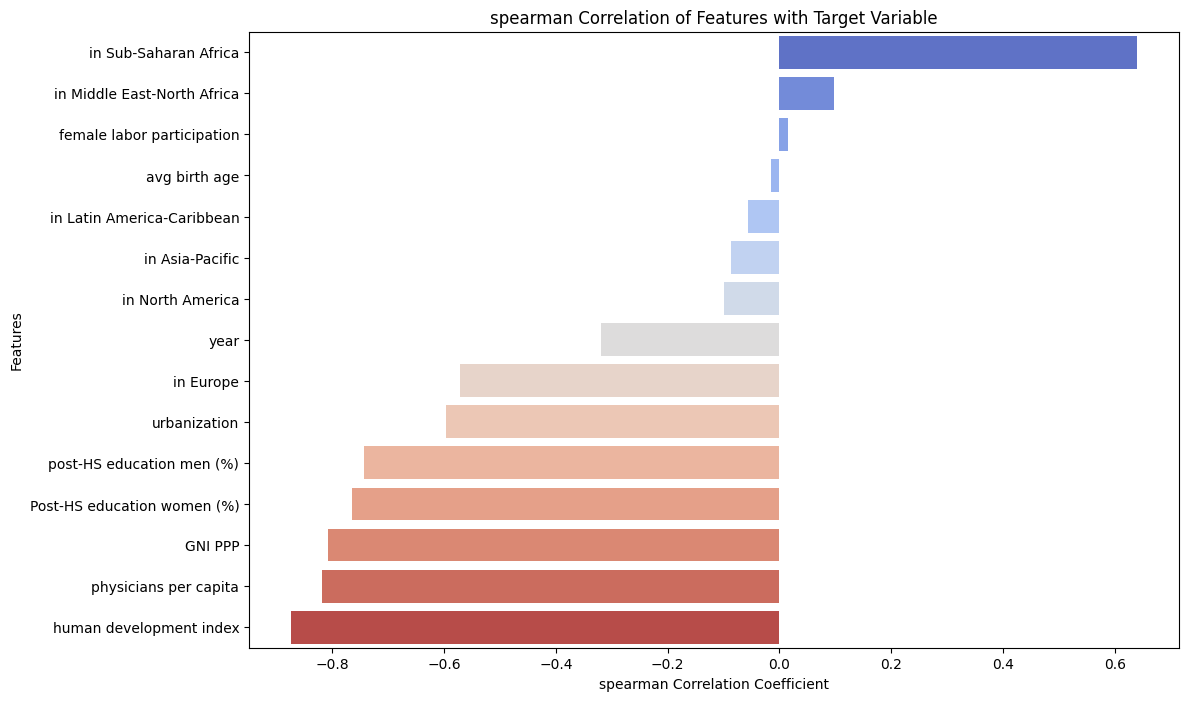


spearman Correlation with Target:
in Sub-Saharan Africa          0.639515
in Middle East-North Africa    0.096987
female labor participation     0.015458
avg birth age                 -0.015935
in Latin America-Caribbean    -0.056877
in Asia-Pacific               -0.086248
in North America              -0.098515
year                          -0.319130
in Europe                     -0.571739
urbanization                  -0.597220
post-HS education men (%)     -0.743266
Post-HS education women (%)   -0.764514
GNI PPP                       -0.808427
physicians per capita         -0.818371
human development index       -0.873707
Name: target, dtype: float64
Mutual Information Scores of Features with Target Variable:
human development index        0.815838
physicians per capita          0.571337
GNI PPP                        0.528822
post-HS education men (%)      0.496540
Post-HS education women (%)    0.495211
in Sub-Saharan Africa          0.283546
avg birth age                  0.236

/tmp/ipython-input-2867624879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')


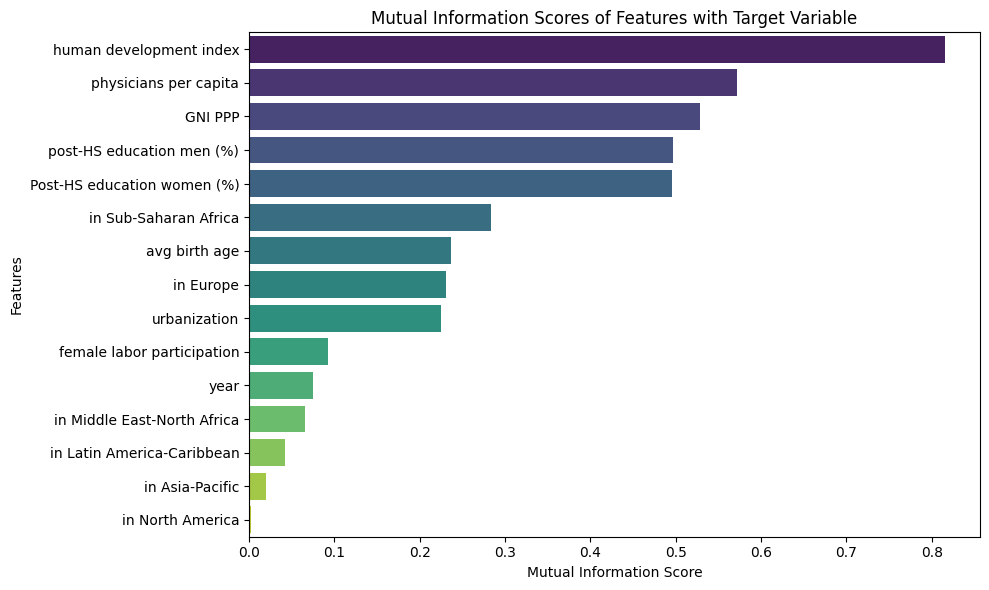


lasso regressor:
Best params: {'lasso__alpha': 0.01}
CV MSE: 0.4033 (±0.6790)
Train accuracy:
MSE: 0.3801

coefficients:
human development index: -1.3940
in Sub-Saharan Africa: 0.5039
avg birth age: 0.3583
in Europe: -0.3303
in Asia-Pacific: -0.2925
female labor participation: -0.0457
year: -0.0181
Post-HS education women (%): 0.0057
GNI PPP: -0.0000
urbanization: 0.0000
physicians per capita: -0.0000
in North America: 0.0000
in Middle East-North Africa: 0.0000
in Latin America-Caribbean: 0.0000
post-HS education men (%): 0.0000

ridge regressor:
Best params: {'ridge__alpha': 3}
CV MSE: 0.4088 (±0.6868)
Train accuracy:
MSE: 0.3769

coefficients:
human development index: -1.3451
in Sub-Saharan Africa: 0.5416
in Europe: -0.3570
avg birth age: 0.3545
in Asia-Pacific: -0.3409
physicians per capita: -0.2001
in North America: 0.0940
in Middle East-North Africa: 0.0549
female labor participation: -0.0538
year: -0.0193
post-HS education men (%): 0.0171
in Latin America-Caribbean: 0.0074
Post-

/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


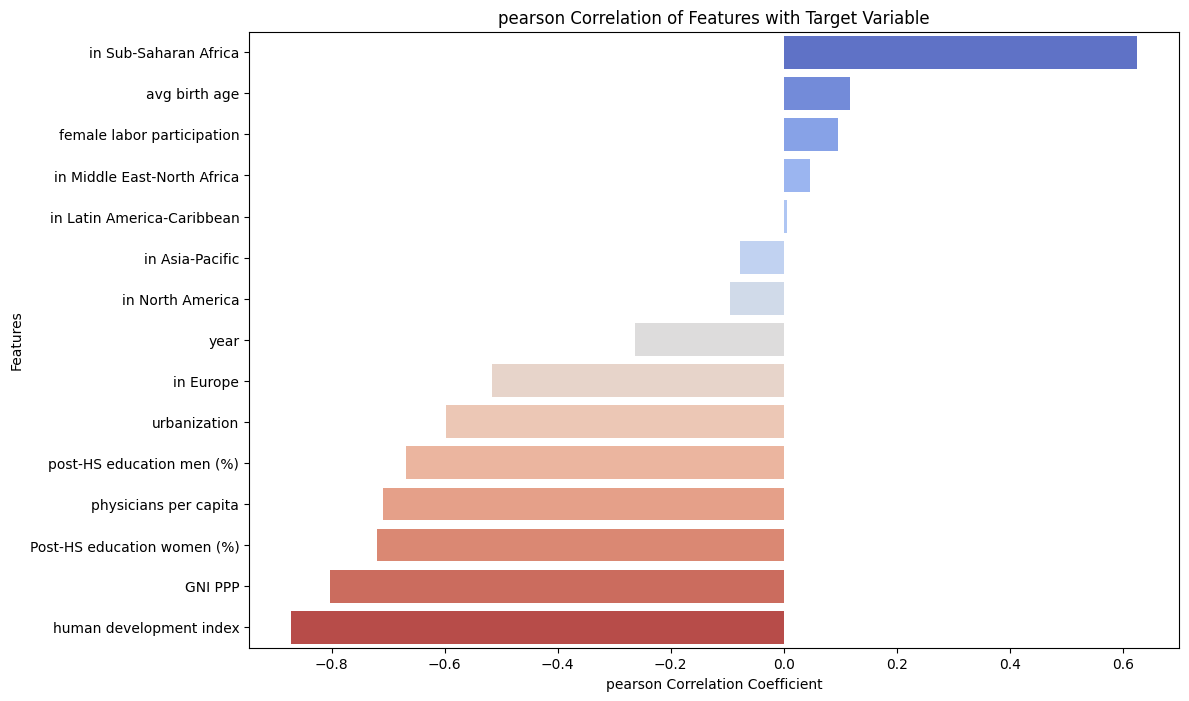


pearson Correlation with Target:
in Sub-Saharan Africa          0.624752
avg birth age                  0.117586
female labor participation     0.095876
in Middle East-North Africa    0.046079
in Latin America-Caribbean     0.004899
in Asia-Pacific               -0.077360
in North America              -0.095160
year                          -0.262590
in Europe                     -0.516671
urbanization                  -0.598252
post-HS education men (%)     -0.669009
physicians per capita         -0.709898
Post-HS education women (%)   -0.719160
GNI PPP                       -0.802528
human development index       -0.871651
Name: target, dtype: float64


/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


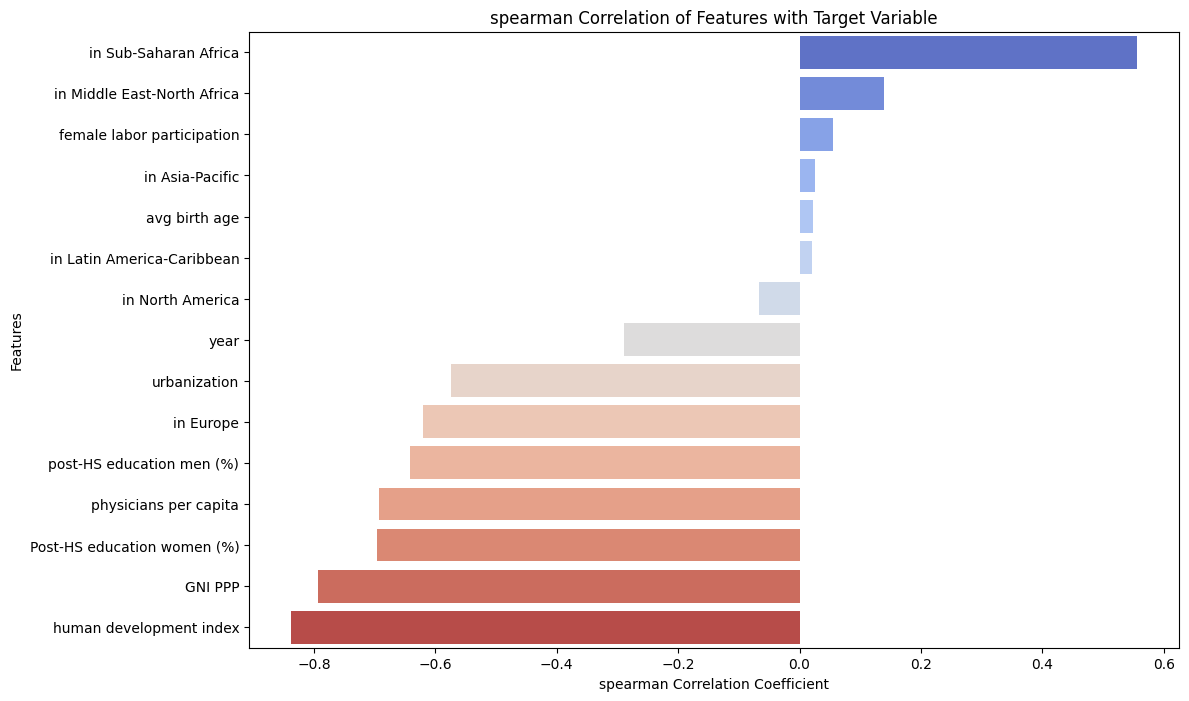


spearman Correlation with Target:
in Sub-Saharan Africa          0.555673
in Middle East-North Africa    0.138885
female labor participation     0.055383
in Asia-Pacific                0.024691
avg birth age                  0.022999
in Latin America-Caribbean     0.020136
in North America              -0.066736
year                          -0.289005
urbanization                  -0.574785
in Europe                     -0.620209
post-HS education men (%)     -0.641906
physicians per capita         -0.692671
Post-HS education women (%)   -0.696786
GNI PPP                       -0.792581
human development index       -0.837396
Name: target, dtype: float64
Mutual Information Scores of Features with Target Variable:
human development index        0.752079
GNI PPP                        0.508089
physicians per capita          0.366169
Post-HS education women (%)    0.339584
post-HS education men (%)      0.339108
avg birth age                  0.253638
in Europe                      0.247

/tmp/ipython-input-2867624879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')


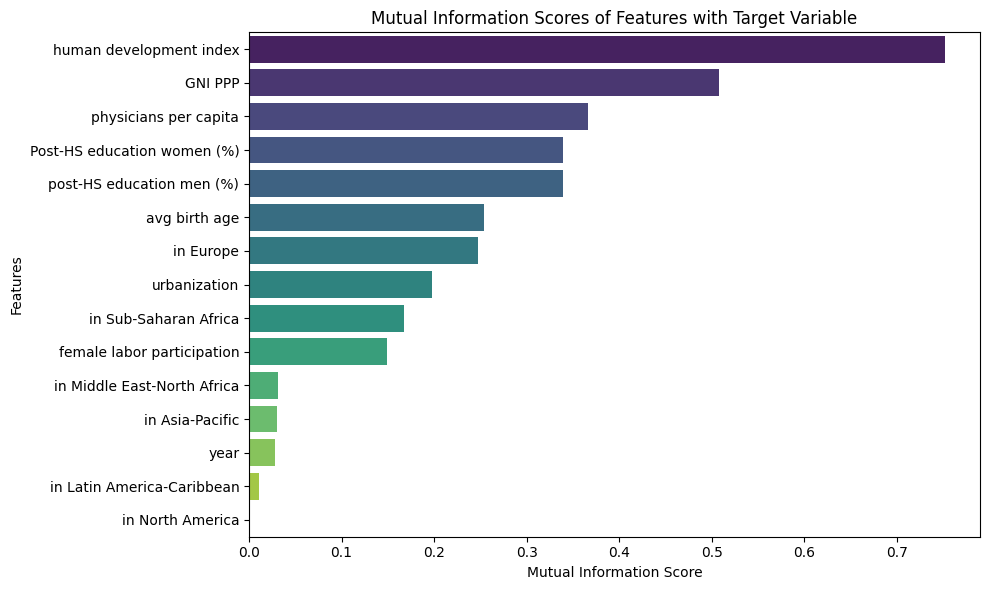

testing trained models signal strength using test set:

lasso regressor final results:
MSE: 0.3461
For: ('Japan', 2023), Actual: 1.2000, Predicted: 1.5604
For: ('Luxembourg', 2023), Actual: 1.2500, Predicted: 1.5871
For: ('Slovak Republic', 2007), Actual: 1.2700, Predicted: 1.6302
For: ('Greece', 2023), Actual: 1.3200, Predicted: 1.5611
For: ('Spain', 1991), Actual: 1.3300, Predicted: 2.3184
For: ('Jamaica', 2023), Actual: 1.3580, Predicted: 2.4328
For: ('Bahamas, The', 2023), Actual: 1.3730, Predicted: 1.9286
For: ('Slovenia', 2007), Actual: 1.3800, Predicted: 1.5812
For: ('Spain', 2007), Actual: 1.3800, Predicted: 1.8499
For: ('Germany', 2023), Actual: 1.3900, Predicted: 1.1220

ridge regressor final results:
MSE: 0.3608
For: ('Japan', 2023), Actual: 1.2000, Predicted: 1.5447
For: ('Luxembourg', 2023), Actual: 1.2500, Predicted: 1.5716
For: ('Slovak Republic', 2007), Actual: 1.2700, Predicted: 1.6124
For: ('Greece', 2023), Actual: 1.3200, Predicted: 1.4413
For: ('Spain', 1991), Actua

In [43]:
data=init_process()

print("2023 data analysis")
X_train_2023, X_test_2023, y_train_2023, y_test_2023, lasso_gs_2023, ridge_gs_2023, rf_gs_2023, xgb_gs_2023 = exec_experiments(data,False)
print("multiple year(1991,2007,2023) data analysis")
X_train_multi, X_test_multi, y_train_multi, y_test_multi, lasso_gs_multi, ridge_gs_multi, rf_gs_multi, xgb_gs_multi = exec_experiments(data,True)

print("testing the success of models for 2023 country fertility rate on subgroups")
test_subgroups(data,False)
print("testing the success of models for multi year country fertility rate on subgroups")
test_subgroups(data,True)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Assuming grid_search_rf, X_train, y_train, X_test, and y_test are already defined

# Get the best trained Random Forest model
best_rf_model = rf_gs.best_estimator_

# --- Evaluate on Training Set ---
y_train_pred_rf = best_rf_model.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

print(f"Training Set Performance:")
print(f"  Mean Squared Error: {mse_train_rf:.4f}")
print(f"  R-squared: {r2_train_rf:.4f}")

print("\n" + "="*50 + "\n")

# --- Evaluate on Test Set ---
y_test_pred_rf = best_rf_model.predict(X_test)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print(f"Test Set Performance:")
print(f"  Mean Squared Error: {mse_test_rf:.4f}")
print(f"  R-squared: {r2_test_rf:.4f}")

print("\n" + "="*50 + "\n")

# --- Validation Set Performance (from Grid Search) ---
# The best_score_ from GridSearchCV is the mean cross-validation score (negative MSE)
validation_neg_mse = rf_gs.best_score_
validation_mse = -validation_neg_mse # Convert negative MSE to positive MSE

print(f"Validation Set Performance (from Grid Search):")
print(f"  Mean Cross-Validation MSE: {validation_mse:.4f}")
# Note: R-squared is not directly available from best_score_ if MSE was the scoring metric
# You could calculate R-squared on the validation folds separately if needed.

Training Set Performance:
  Mean Squared Error: 0.0740
  R-squared: 0.9602


Test Set Performance:
  Mean Squared Error: 0.1473
  R-squared: 0.8882


Validation Set Performance (from Grid Search):
  Mean Cross-Validation MSE: 0.3397


In [45]:
    import dill

    filename = 'my_session.pkl'
    dill.dump_session(filename)

In [ ]:
    import dill

    filename = 'my_session.pkl'
    dill.load_session(filename)

In [1]:
import dill

filename = 'my_session (3).pkl'
dill.load_session(filename)

In [ ]:
# Assume best_lasso_2023, X_test_2023, and y_test_2023 are defined in the environment

countries_to_predict = ['Korea, Rep.', 'China', 'Japan', 'Sweden', 'Czechia']

print("Comparison of Predicted vs. Actual Target Values (Lasso - 2023 Data):")
print("-" * 60)

for country in countries_to_predict:
    if (country, 2023) in X_test_2023.index and (country, 2023) in y_test_2023.index:
        country_data = X_test_2023.loc[[(country, 2023)]] # Use double brackets to keep it as a DataFrame
        actual_target = y_test_2023.loc[(country, 2023)]

        # Predict using the best Lasso model
        predicted_target = best_lasso_2023.predict(country_data)

        print(f"{country}: Predicted = {predicted_target[0]:.4f}, Actual = {actual_target:.4f}")
    else:
        print(f"Data for '{country}' (2023) not found in test sets.")

print("-" * 60)

Comparison of Predicted vs. Actual Target Values (Lasso - 2023 Data):
------------------------------------------------------------
Korea, Rep.: Predicted = 0.9431, Actual = 0.7210
China: Predicted = 1.5210, Actual = 0.9990
Japan: Predicted = 1.3713, Actual = 1.2000
Sweden: Predicted = 1.2514, Actual = 1.4500
Czechia: Predicted = 1.3296, Actual = 1.4500
------------------------------------------------------------


In [ ]:
display(X_train_2023)

,,urbanization,avg birth age,happiness index,health expenditure,physicians per capita,GNI PPP,female labor participation,christians (%),muslims (%),no religion (%),...,Post-HS education women (%),human development index,gender inequality index,first marriage age women,first marriage age men,maternity leave index,work hours men,work hours women,abortion rate,social media users
country,year,,,,,,,,,,,,,,,,,,,,,
Malaysia,2023,76.783676,30.960,5.975,1280.890765,2.316,35360.0,51.573,9.153185,64.117195,0.844679,...,79.029999,0.819,0.172,31.0,30.2,14.0000,45.31,43.35,11.0,0.797158
"Gambia, The",2023,41.470592,29.823,4.485,88.690523,0.102,3220.0,45.242,2.893368,97.002708,0.017932,...,35.504486,0.524,0.578,30.7,26.7,12.0000,44.09,31.11,16.0,0.143156
Albania,2023,61.257164,29.132,5.304,1186.215336,1.883,20990.0,53.207,17.815659,74.507225,7.652887,...,90.499878,0.810,0.107,30.9,29.4,23.2300,43.26,39.07,1.2,0.552046
Benin,2023,50.171100,29.079,4.377,105.518782,0.195,4090.0,74.183,53.231159,31.401228,4.885910,...,7.217570,0.515,0.573,24.4,22.2,14.0000,43.80,41.17,32.0,0.145128
Eswatini,2023,27.941381,27.891,3.502,761.853341,1.591,10560.0,44.886,93.228432,0.135700,6.155977,...,45.820789,0.695,0.484,30.5,28.5,0.0000,43.38,38.71,29.0,0.326628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Latvia,2023,71.988180,30.317,6.234,3139.066911,3.377,40510.0,55.383,77.267601,0.670409,16.973822,...,97.205177,0.889,0.117,32.7,31.7,10.2400,36.67,33.23,6.4,0.787673
Rwanda,2023,24.698296,30.590,3.268,222.124218,0.116,3330.0,58.044,97.033600,1.807574,1.007935,...,20.517868,0.578,0.394,24.7,22.7,5.3868,32.65,27.93,28.0,0.063860
Bolivia,2023,71.371340,28.144,5.784,830.752592,1.269,10620.0,71.909,88.925598,0.009802,9.547658,...,57.391281,0.733,0.419,26.6,25.4,4.1160,40.98,34.17,38.0,0.600073


Features DataFrame:


מאפיינים/מטרה,first marriage age men,first marriage age women,urbanization,avg birth age,GNI PPP,physicians per capita,health expenditure,maternity leave index,social media users,abortion rate,...,buddhists (%),hindus (%),no religion (%),other religion (%),in Middle East-North Africa,in Europe,in North America,in Sub-Saharan Africa,in Latin America-Caribbean,in Asia-Pacific
חרדים,23.00,22.00,91.53,31.3,29213.0,3.713,4008.0,14.0,0.3200,8.10,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
יהודים לא חרדים,30.00,28.00,74.26,31.3,51498.0,3.713,4008.0,14.0,0.9110,8.10,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ערבים,26.96,23.11,42.50,27.7,29420.0,3.713,4008.0,14.0,0.7128,5.99,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0



Target DataFrame:


מאפיינים/מטרה,target
חרדים,6.40
יהודים לא חרדים,2.50
ערבים,2.75


In [47]:
# Filter out Israel from the 2023 training data
X_train_2023_no_israel = X_train_2023.drop(index=('Israel', 2023), errors='ignore')
y_train_2023_no_israel = y_train_2023.drop(index=('Israel', 2023), errors='ignore')

# Initialize the scaler for 2023 data
scaler_2023_no_israel = Scaling2023()

# Retrain Lasso on the data without Israel
print('Lasso regressor (excluding Israel):')
lasso_gs_2023_no_israel = gridsearch_loocv_lasso(X_train_2023_no_israel, y_train_2023_no_israel, scaler_2023_no_israel)
report_grid_search(lasso_gs_2023_no_israel, X_train_2023_no_israel, 'lasso', scaler_2023_no_israel)

# Retrain Ridge on the data without Israel
print('\nRidge regressor (excluding Israel):')
# Assuming you have a gridsearch_ridge_loocv function defined, similar to the others
# If not, I can generate it. For now, I'll assume it exists.
# If it doesn't exist, the execution will fail, and I'll generate it in the next step.
ridge_gs_2023_no_israel = gridsearch_ridge_loocv(X_train_2023_no_israel, y_train_2023_no_israel, scaler_2023_no_israel)
report_grid_search(ridge_gs_2023_no_israel, X_train_2023_no_israel, 'ridge', scaler_2023_no_israel)

Lasso regressor (excluding Israel):


KeyboardInterrupt: 

In [4]:
import pandas as pd

# Filter out Israel from the 2023 training data
X_train_2023_no_israel = X_train_2023.drop(index=('Israel', 2023), errors='ignore')
y_train_2023_no_israel = y_train_2023.drop(index=('Israel', 2023), errors='ignore')

# Ensure the new features_df has the same columns as X_train_2023 in the same order
features_df_reindexed = features_df.reindex(columns=X_train_2023.columns)

# Initialize the scaler for 2023 data and fit on the data without Israel
scaler_2023_no_israel = Scaling2023()
scaler_2023_no_israel.fit(X_train_2023_no_israel)

# Initialize the models with the best parameters found previously
best_lasso_params_2023 = lasso_gs_2023.best_params_['lasso__alpha']
best_ridge_params_2023 = ridge_gs_2023.best_params_['ridge__alpha']
best_rf_params_2023 = rf_gs_2023.best_params_
best_xgb_params_2023 = xgb_gs_2023.best_params_

# Retrain the models on the data without Israel
retrained_lasso_2023 = Pipeline([('scaler', scaler_2023_no_israel), ('lasso', Lasso(alpha=best_lasso_params_2023))])
retrained_lasso_2023.fit(X_train_2023_no_israel, y_train_2023_no_israel)

retrained_ridge_2023 = Pipeline([('scaler', scaler_2023_no_israel), ('ridge', Ridge(alpha=best_ridge_params_2023))])
retrained_ridge_2023.fit(X_train_2023_no_israel, y_train_2023_no_israel)

retrained_rf_2023 = Pipeline([('scaler', scaler_2023_no_israel), ('rf', RandomForestRegressor(random_state=42, n_jobs=-1, **{k.replace('rf__', ''): v for k, v in best_rf_params_2023.items()}))])
retrained_rf_2023.fit(X_train_2023_no_israel, y_train_2023_no_israel)

retrained_xgb_2023 = Pipeline([('scaler', scaler_2023_no_israel), ('xgb', XGBRegressor(tree_method='hist', random_state=42, n_jobs=-1, importance_type='gain', **{k.replace('xgb__', ''): v for k, v in best_xgb_params_2023.items()}))])
retrained_xgb_2023.fit(X_train_2023_no_israel, y_train_2023_no_israel)


print("Predictions for the new data using regressors retrained without Israel:")
print("-" * 60)

retrained_regressors_2023 = {
    "Lasso": retrained_lasso_2023,
    "Ridge": retrained_ridge_2023,
    "Random Forest": retrained_rf_2023,
    "XGBoost": retrained_xgb_2023
}

for name, estimator in retrained_regressors_2023.items():
    predicted_target = estimator.predict(features_df_reindexed)

    print(f"{name} Predictions:")
    for index, prediction in zip(features_df_reindexed.index, predicted_target):
        print(f"  {index}: {prediction:.4f}")
    print("-" * 20)

# Compare with actual target values
print("\nActual Target Values:")
print("-" * 60)
display(target_df)
print("-" * 60)

Predictions for the new data using regressors retrained without Israel:
------------------------------------------------------------
Lasso Predictions:
  חרדים: 3.0297
  יהודים לא חרדים: 0.8205
  ערבים: 1.4959
--------------------
Ridge Predictions:
  חרדים: 3.4573
  יהודים לא חרדים: 1.2697
  ערבים: 1.9511
--------------------
Random Forest Predictions:
  חרדים: 1.9381
  יהודים לא חרדים: 1.2629
  ערבים: 1.6616
--------------------
XGBoost Predictions:
  חרדים: 2.2881
  יהודים לא חרדים: 1.7080
  ערבים: 1.9248
--------------------

Actual Target Values:
------------------------------------------------------------


מאפיינים/מטרה,target
חרדים,6.40
יהודים לא חרדים,2.50
ערבים,2.75


------------------------------------------------------------
